<a href="https://colab.research.google.com/github/CristinaMarsh/100-Days-Of-ML-Code/blob/master/TStool/Gluonts_day3(4)_Dataset_func_and_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepAR_nbcu

https://github.com/keemsunguk/gluonts/blob/master/sagemaker-studiolab-notebooks/deepAR_nbcu.ipynb

In [8]:
#how to write a requirement
%%writefile requirements.txt

ipywidgets
matplotlib
ujson
pathlib
#mxnet
mxnet-cu101
gluonts

Overwriting requirements.txt


In [9]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 16 kB/s 


In [10]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:

%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
from pathlib import Path

In [12]:
from mxnet import gpu

from gluonts.dataset.util import to_pandas
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import Evaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import NegativeBinomialOutput
from gluonts.evaluation import make_evaluation_predictions

In [22]:
mx.context.num_gpus()

1

## loading data

In [16]:
! git clone https://github.com/keemsunguk/gluonts.git

Cloning into 'gluonts'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 6), reused 27 (delta 5), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [17]:
%cd gluonts/

/content/gluonts


In [21]:
daily_data_dir = Path('/content/gluonts/sagemaker-studiolab-notebooks/data')

In [22]:
daily_data_dir

PosixPath('/content/gluonts/sagemaker-studiolab-notebooks/data')

In [23]:
nbcu_comp_train = pd.read_csv(daily_data_dir/"nbcu_ad_req_10yr_train.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_train.columns = ['site_id', 'inventory']
nbcu_comp_test = pd.read_csv(daily_data_dir/"nbcu_ad_req_10yr_test.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_test.columns = ['site_id', 'inventory']
event_ts = pd.read_csv(daily_data_dir/"event_ts_2021-12-05.csv", index_col=1, parse_dates=True, header=None)
event_ts.columns = ['site_id', 'nfl', 'so', 'wo']

In [24]:
print('Train:', nbcu_comp_train.shape)
print('Test:', nbcu_comp_test.shape)
print('Event:', event_ts.shape)

Train: (3647, 2)
Test: (41, 2)
Event: (3688, 4)


In [27]:
nbcu_comp_train.head()

site_id  inventory
1                             
2011-11-01   169843     475599
2011-11-02   169843     550997
2011-11-03   169843     593800
2011-11-04   169843     569588
2011-11-05   169843     500787

In [25]:
ds_meta = {
    'num_series': 1,
    'num_steps': nbcu_comp_train.shape[0],
    'prediction_length': nbcu_comp_test.shape[0],
    'validation_length': nbcu_comp_test.shape[0],
    'freq': '1D',
    'start': [
        nbcu_comp_train.index[0]
        for _ in range(1)
    ]
}

In [26]:
[nbcu_comp_train.index[0] for _ in range(1)]

[Timestamp('2011-11-01 00:00:00')]

In [28]:
merged_df = pd.concat(
    [nbcu_comp_train, nbcu_comp_test], axis=0
)

In [29]:
def plot_prob_forecasts(ts_entry, forecast_entry, plot_length=150, prediction_intervals = (10.0, 90.0)):
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [31]:
merged_df.pivot_table(index=merged_df.index, columns=['site_id']).fillna(0)

inventory                                                         \
1       2011-11-01 2011-11-02 2011-11-03 2011-11-04 2011-11-05 2011-11-06   
site_id                                                                     
169843      475599     550997     593800     569588     500787     361853   

                                                     ...             \
1       2011-11-07 2011-11-08 2011-11-09 2011-11-10  ... 2021-11-26   
site_id                                              ...              
169843      373991     508492     548294     602030  ...  109753307   

                                                                           \
1       2021-11-27 2021-11-28 2021-11-29 2021-11-30 2021-12-01 2021-12-02   
site_id                                                                     
169843    93582518  101176884  123736245  102589478  106385482  107295734   

                                          
1       2021-12-03 2021-12-04 2021-12-05  
site_id                                   
169843   103982951  101222682   99848104  

[1 rows x 3688 columns]

In [32]:
event_ts[['nfl', 'so', 'wo']]

nfl  so  wo
1                      
2011-11-01    0   0   0
2011-11-02    0   0   0
2011-11-03    0   0   0
2011-11-04    0   0   0
2011-11-05    0   0   0
...         ...  ..  ..
2021-12-01    0   0   0
2021-12-02    0   0   0
2021-12-03    0   0   0
2021-12-04    0   0   0
2021-12-05    0   0   0

[3688 rows x 3 columns]

In [34]:
event_ts[:-(16+24)].transpose()

1        2011-11-01  2011-11-02  2011-11-03  2011-11-04  2011-11-05  \
site_id      169843      169843      169843      169843      169843   
nfl               0           0           0           0           0   
so                0           0           0           0           0   
wo                0           0           0           0           0   

1        2011-11-06  2011-11-07  2011-11-08  2011-11-09  2011-11-10  ...  \
site_id      169843      169843      169843      169843      169843  ...   
nfl               0           0           0           0           0  ...   
so                0           0           0           0           0  ...   
wo                0           0           0           0           0  ...   

1        2021-10-17  2021-10-18  2021-10-19  2021-10-20  2021-10-21  \
site_id      169843      169843      169843      169843      169843   
nfl               0           1           0           0           0   
so                0           0           0           0           0   
wo                0           0           0           0           0   

1        2021-10-22  2021-10-23  2021-10-24  2021-10-25  2021-10-26  
site_id      169843      169843      169843      169843      169843  
nfl               0           0           0           1           0  
so                0           0           0           0           0  
wo                0           0           0           0           0  

[4 rows x 3648 columns]

## Dataset Func

In [30]:
def network_dataset(data_df:pd, event, freq='D', valid_length=0, test_length=0):
    # data_df: base dataset from by network inventories
    data_df = data_df.pivot_table(index=data_df.index, columns=['site_id']).fillna(0)
    
    #remove this line after testing
    #data_df = data_df[1:2]
    
    num_series, num_steps = data_df.shape
    print(num_series, num_steps, data_df.columns[0][1]) 
    
    train_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-(valid_length+test_length)],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-(valid_length+test_length)].transpose(),
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    valid_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-test_length],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-test_length].transpose(),
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )    
    test_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r,
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event.transpose(),
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    
    return train_ds, valid_ds, test_ds #target, feat_dynamic_real, feat_static_cat

## Data set prep and review

In [35]:
train_ds, valid_ds, test_ds = network_dataset(
    merged_df, 
    event_ts[['nfl', 'so', 'wo']].values,
    freq=ds_meta['freq'],
    valid_length=ds_meta['validation_length'],
    test_length=ds_meta['prediction_length']
)

1 3688 2011-11-01 00:00:00


In [36]:
train_entry = next(iter(train_ds))
train_entry.keys()
valid_entry = next(iter(valid_ds))
valid_entry.keys()
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['item_id', 'target', 'start', 'feat_dynamic_real', 'feat_static_cat'])

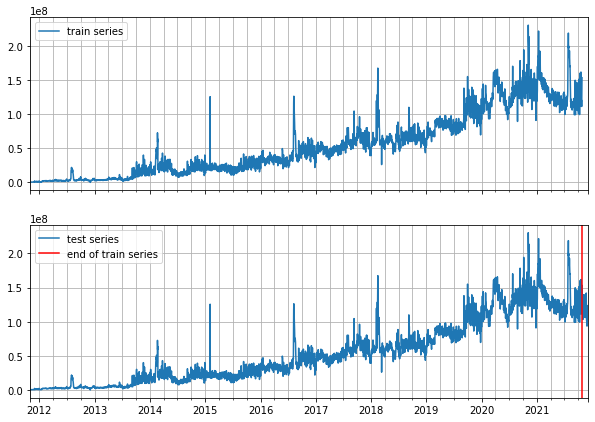

In [37]:
test_series = to_pandas(test_entry)
valid_series = to_pandas(valid_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

valid_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(valid_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Training

In [40]:
# No trainer
deepAR_estimator = DeepAREstimator(
    prediction_length=ds_meta['prediction_length'],
    context_length=3*ds_meta['prediction_length'],
    freq=ds_meta['freq'],
    num_layers=5,
    num_cells=90,
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=False,
#    cardinality=stat_cat_cardinalities,
    dropout_rate=0.1,
    cell_type='lstm',
    trainer=Trainer(   
        ctx=gpu(0),
        learning_rate=1e-3,
        epochs=20,
        num_batches_per_epoch=90,
        batch_size=128
    )
)

In [41]:
deepAR_predictor = deepAR_estimator.train(training_data=train_ds, validation_data=valid_ds)

100%|██████████| 90/90 [00:30<00:00,  2.94it/s, epoch=1/20, avg_epoch_loss=7.14]
1it [00:00,  1.27it/s, epoch=1/20, validation_avg_epoch_loss=1.01]
100%|██████████| 90/90 [00:28<00:00,  3.16it/s, epoch=2/20, avg_epoch_loss=6.17]
1it [00:00,  1.49it/s, epoch=2/20, validation_avg_epoch_loss=14.6]
100%|██████████| 90/90 [00:28<00:00,  3.12it/s, epoch=3/20, avg_epoch_loss=4.02]
1it [00:00,  1.54it/s, epoch=3/20, validation_avg_epoch_loss=21.4]
100%|██████████| 90/90 [00:28<00:00,  3.15it/s, epoch=4/20, avg_epoch_loss=3.98]
1it [00:00,  1.55it/s, epoch=4/20, validation_avg_epoch_loss=15.1]
100%|██████████| 90/90 [00:28<00:00,  3.19it/s, epoch=5/20, avg_epoch_loss=3.48]
1it [00:00,  1.54it/s, epoch=5/20, validation_avg_epoch_loss=13.6]
100%|██████████| 90/90 [00:27<00:00,  3.22it/s, epoch=6/20, avg_epoch_loss=4.07]
1it [00:00,  1.52it/s, epoch=6/20, validation_avg_epoch_loss=5.42]
100%|██████████| 90/90 [00:28<00:00,  3.18it/s, epoch=7/20, avg_epoch_loss=4.17]
1it [00:00,  1.51it/s, epoch=7/

In [42]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=deepAR_predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

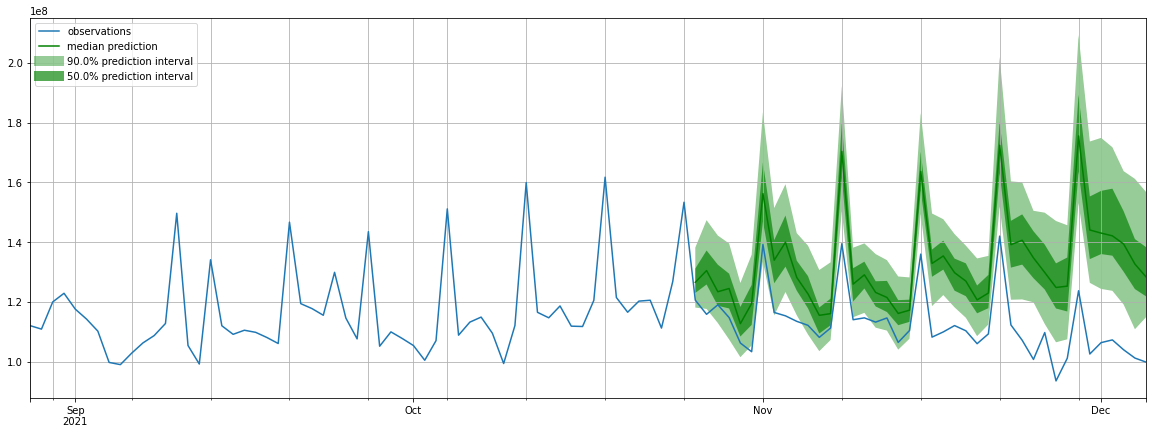

In [43]:

for i in range(1):
    plot_prob_forecasts(tss[i], forecasts[i], plot_length=100, prediction_intervals = (50.0, 90.0))

In [44]:

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


In [45]:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 600266776772608.0,
    "abs_error": 844661312.0,
    "abs_target_sum": 4612718592.0,
    "abs_target_mean": 112505331.51219513,
    "seasonal_error": 5116456.724081185,
    "MASE": 4.026516107850745,
    "MAPE": 0.1854770823222835,
    "sMAPE": 0.16552804156047543,
    "MSIS": 46.92187209755254,
    "QuantileLoss[0.1]": 694245491.1999999,
    "Coverage[0.1]": 0.8048780487804879,
    "QuantileLoss[0.5]": 844661336.0,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 288699209.59999996,
    "Coverage[0.9]": 1.0,
    "RMSE": 24500342.38072211,
    "NRMSE": 0.21777050075236987,
    "ND": 0.18311572560808842,
    "wQuantileLoss[0.1]": 0.15050679493087965,
    "wQuantileLoss[0.5]": 0.1831157308110939,
    "wQuantileLoss[0.9]": 0.06258764844243937,
    "mean_absolute_QuantileLoss": 609202012.2666665,
    "mean_wQuantileLoss": 0.13207005806147096,
    "MAE_Coverage": 0.434959349593496,
    "OWA": NaN
}


In [46]:
item_metrics

item_id           MSE    abs_error  abs_target_sum  abs_target_mean  \
0  169843.0  6.002668e+14  844661312.0    4.612719e+09     1.125053e+08   

   seasonal_error      MASE      MAPE     sMAPE        ND       MSIS  \
0    5.116457e+06  4.026516  0.185477  0.165528  0.183116  46.921872   

   QuantileLoss[0.1]  Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  \
0        694245491.2       0.804878        844661336.0            1.0   

   QuantileLoss[0.9]  Coverage[0.9]  
0        288699209.6            1.0

In [47]:

fc_val = forecasts[0].samples
fc_mean = fc_val.mean(axis=0)
display_df = nbcu_comp_test.copy()
display_df['p50'] = fc_mean
display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)

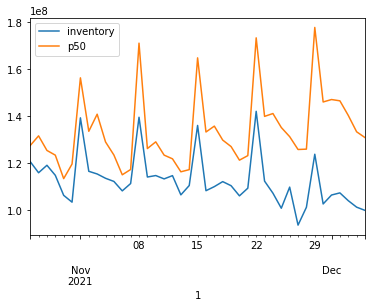

In [48]:
display_df[['inventory', 'p50']].plot()

In [49]:

display_df['deviation'].mean()

19.246353497577623

## No Event Training

In [50]:
def network_dataset(data_df:pd, event, freq='D', valid_length=0, test_length=0):
    # data_df: base dataset from by network inventories
    data_df = data_df.pivot_table(index=data_df.index, columns=['site_id']).fillna(0)
    
    #remove this line after testing
    #data_df = data_df[1:2]
    
    num_series, num_steps = data_df.shape
    print(num_series, num_steps, data_df.columns[0][1]) 
    
    train_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-(valid_length+test_length)],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-(valid_length+test_length)] if event else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    valid_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-test_length],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-test_length] if event else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )    
    test_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r,
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event if event else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    
    return train_ds, valid_ds, test_ds #target, feat_dynamic_real, feat_static_cat

In [51]:
train_ds2, valid_ds2, test_ds2 = network_dataset(
    merged_df, 
    False,
    freq=ds_meta['freq'],
    valid_length=0, #ds_meta['validation_length'],
    test_length=ds_meta['prediction_length']
)

1 3688 2011-11-01 00:00:00


In [52]:
deepAR_estimator = DeepAREstimator(
    prediction_length=ds_meta['prediction_length'],
    context_length=3688,
    freq=ds_meta['freq'],
    num_layers=5,
    num_cells=90,
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
#    cardinality=stat_cat_cardinalities,
    dropout_rate=0.1,
    cell_type='lstm',
    trainer=Trainer(   
#        ctx=gpu(0),
        learning_rate=1e-3, patience=50,
        epochs=100,
        num_batches_per_epoch=90,
#        batch_size=64
    )
)

In [ ]:

deepAR_predictor = deepAR_estimator.train(training_data=train_ds2)

  0%|          | 0/90 [00:00<?, ?it/s]

## deepAR_by_site_find_optimize

https://github.com/keemsunguk/gluonts/blob/master/sagemaker-studiolab-notebooks/deepAR_by_site_find_optimize.ipynb

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
from pathlib import Path

In [2]:
from gluonts.dataset.util import to_pandas
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import Evaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import NegativeBinomialOutput
from gluonts.evaluation import make_evaluation_predictions

In [5]:
daily_data_dir = Path('/content/gluonts/sagemaker-studiolab-notebooks/data')

In [8]:
nbcu_comp_train = pd.read_csv(daily_data_dir/"nbcu_train_validation.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_train.columns = ['site_id', 'inventory']
nbcu_comp_test = pd.read_csv(daily_data_dir/"nbcu_blindtest_1.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_test.columns = ['site_id', 'inventory']
event_ts = pd.read_csv(daily_data_dir/"event_ts_2021-12-05.csv", index_col=1, parse_dates=True, header=None)
event_ts.columns = ['site_id', 'nfl', 'so', 'wo']

In [9]:
event_ts

site_id  nfl  so  wo
1                               
2011-11-01   169843    0   0   0
2011-11-02   169843    0   0   0
2011-11-03   169843    0   0   0
2011-11-04   169843    0   0   0
2011-11-05   169843    0   0   0
...             ...  ...  ..  ..
2021-12-01   169843    0   0   0
2021-12-02   169843    0   0   0
2021-12-03   169843    0   0   0
2021-12-04   169843    0   0   0
2021-12-05   169843    0   0   0

[3688 rows x 4 columns]

In [10]:
event_ts = event_ts[['nfl', 'so', 'wo']][2618:-127]
event_ts

nfl  so  wo
1                      
2019-01-01    0   0   0
2019-01-02    0   0   0
2019-01-03    0   0   0
2019-01-04    0   0   0
2019-01-05    0   0   0
...         ...  ..  ..
2021-07-27    0   1   0
2021-07-28    0   1   0
2021-07-29    0   1   0
2021-07-30    0   1   0
2021-07-31    0   1   0

[943 rows x 3 columns]

In [11]:
usable_sites = pd.read_csv(daily_data_dir/"non_zero_2021-05-31.csv", header=None)[0].to_list()

In [12]:
print('Train:', nbcu_comp_train.shape)
print('Test:', nbcu_comp_test.shape)
print('Event:', event_ts.shape)

Train: (1554966, 2)
Test: (41236, 2)
Event: (943, 3)


In [13]:
merged_df = pd.concat(
    [nbcu_comp_train, nbcu_comp_test], axis=0
)

In [14]:
selected_df = merged_df.loc[merged_df['site_id'].isin(usable_sites)]
selected_df

site_id  inventory
1                             
2019-01-01   206024     6789.0
2019-01-01   208993     2561.0
2019-01-01   235406    12935.0
2019-01-01   235407     4483.0
2019-01-01   416811   506297.0
...             ...        ...
2021-07-31   921103     5421.0
2021-07-31   921211   122600.0
2021-07-31   927421        0.0
2021-07-31   929242    57518.0
2021-07-31   945745        0.0

[476215 rows x 2 columns]

In [15]:
#Definite ds_meta
ds_meta = {
    'num_series': selected_df['site_id'].unique().shape[0],
    'num_steps': nbcu_comp_train.index.unique().shape[0],
    'prediction_length': nbcu_comp_test.index.unique().shape[0],
    'validation_length': nbcu_comp_test.index.unique().shape[0]*2,
    'freq': '1D',
    'start': [
        nbcu_comp_train.index[0]
        for _ in range(1)
    ]
}

In [16]:

ds_meta

{'freq': '1D',
 'num_series': 505,
 'num_steps': 882,
 'prediction_length': 61,
 'start': [Timestamp('2019-01-01 00:00:00')],
 'validation_length': 122}

In [17]:
def plot_prob_forecasts(ts_entry, forecast_entry, plot_length=150, prediction_intervals = (10.0, 90.0)):
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

## data-set func

In [18]:
def network_dataset(data_df:pd, event, freq='D', valid_length=0, test_length=0):
    # data_df: base dataset from by network inventories
    data_df = data_df.pivot_table(index=data_df.index, columns=['site_id']).fillna(0)
    
    #remove this line after testing
    #data_df = data_df[1:2]
    
    num_series, num_steps = data_df.shape
    print(num_series, num_steps, data_df.columns[0][1]) 
    
    train_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-(valid_length+test_length)],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-(valid_length+test_length)].transpose() if len(event) > 0  else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    valid_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-test_length],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-test_length].transpose() if len(event) > 0  else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )    
    test_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r,
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event.transpose() if len(event) > 0  else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    
    return train_ds, valid_ds, test_ds #target, feat_dynamic_real, feat_static_cat

In [19]:
train_ds, valid_ds, test_ds = network_dataset(
    selected_df, 
    event_ts[['nfl', 'so', 'wo']].values,
    freq=ds_meta['freq'],
    valid_length=0, #ds_meta['validation_length'],
    test_length=ds_meta['prediction_length']
)

505 943 2019-01-01 00:00:00


In [20]:
train_entry = next(iter(train_ds))
train_entry.keys()
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['item_id', 'target', 'start', 'feat_dynamic_real', 'feat_static_cat'])

## Training

100%|██████████| 90/90 [00:18<00:00,  4.75it/s, epoch=10/10, avg_epoch_loss=7.21]


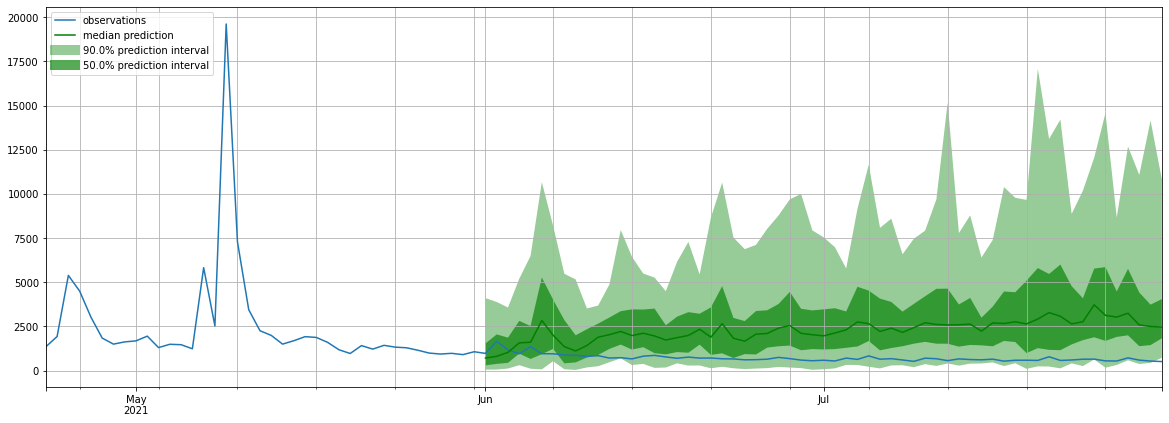

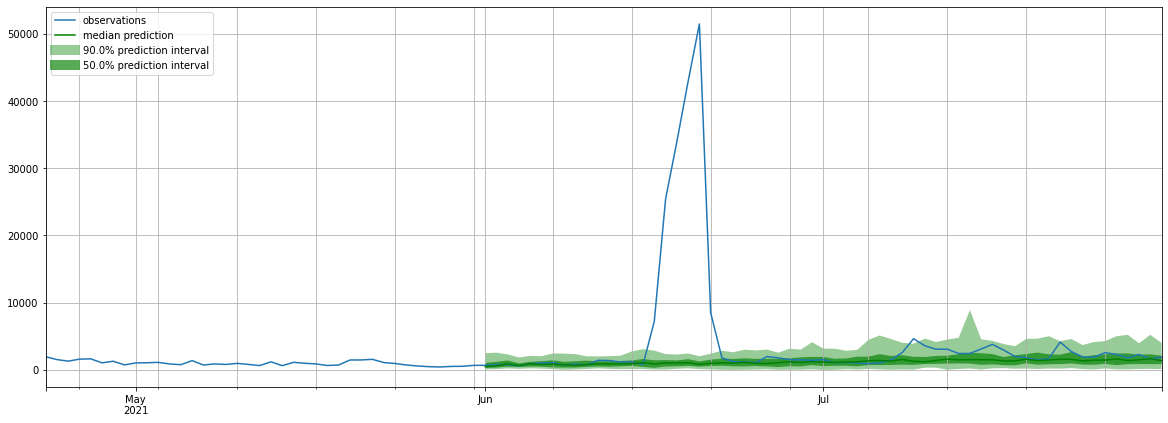

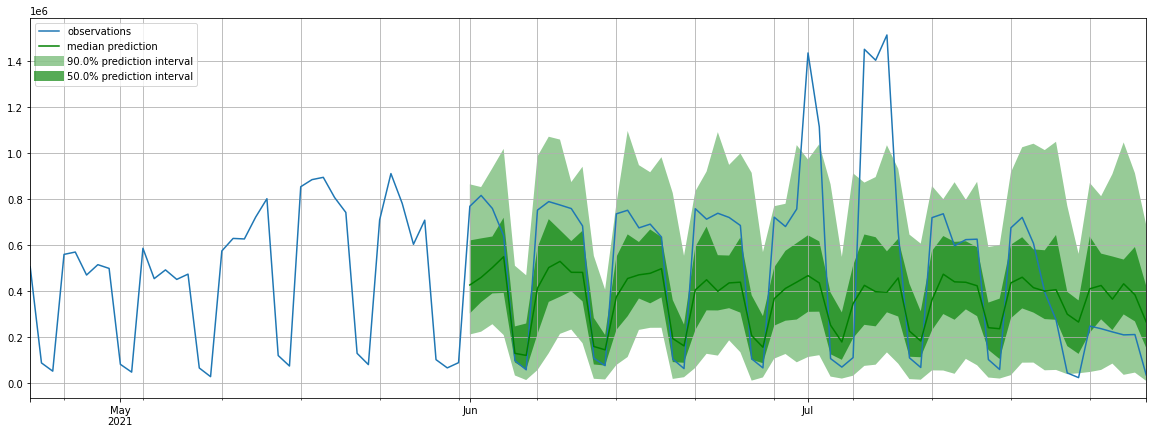

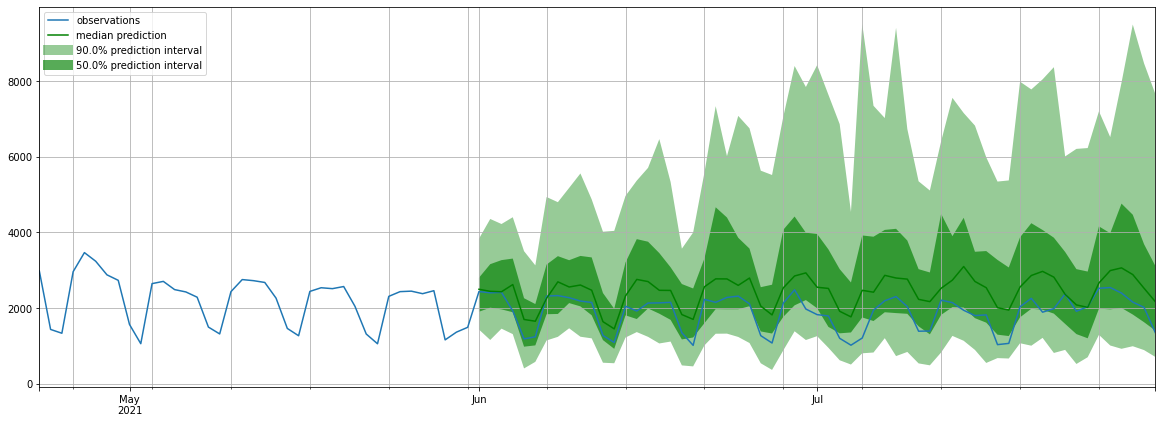

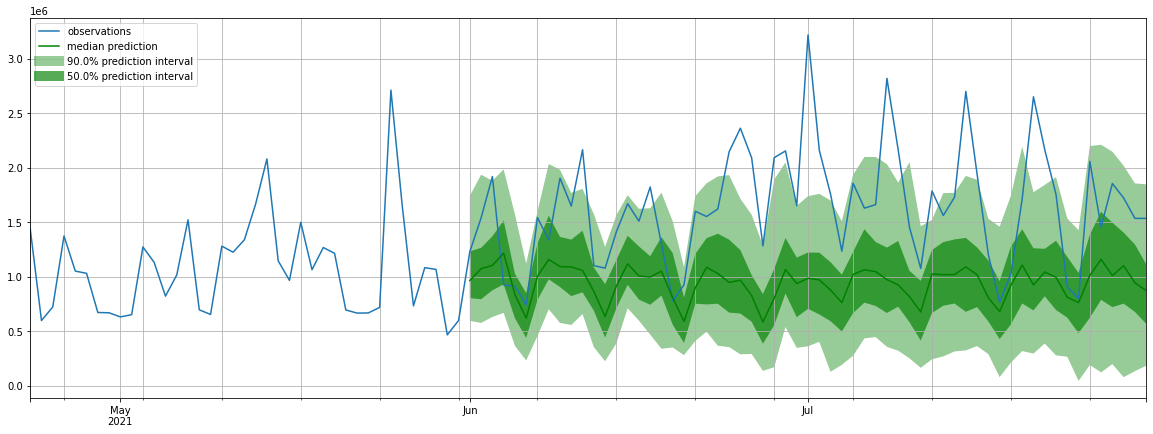

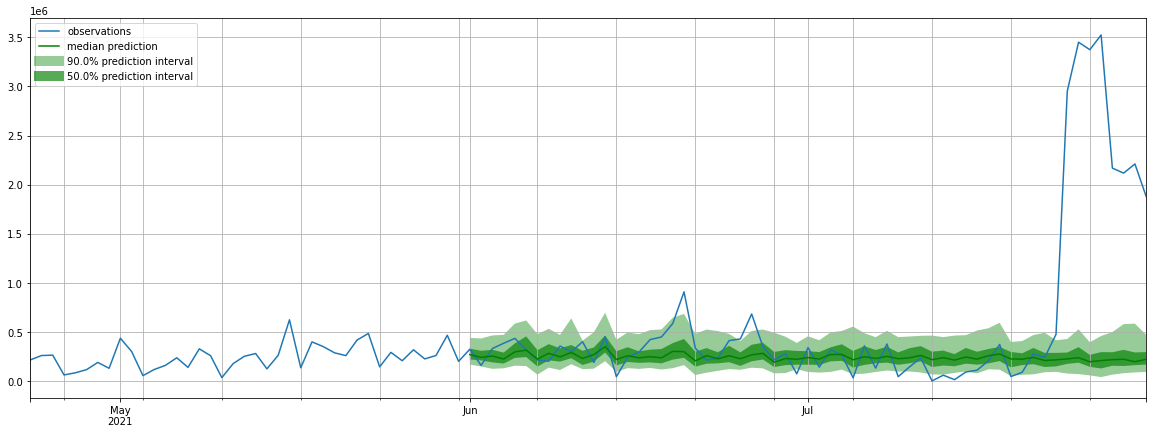

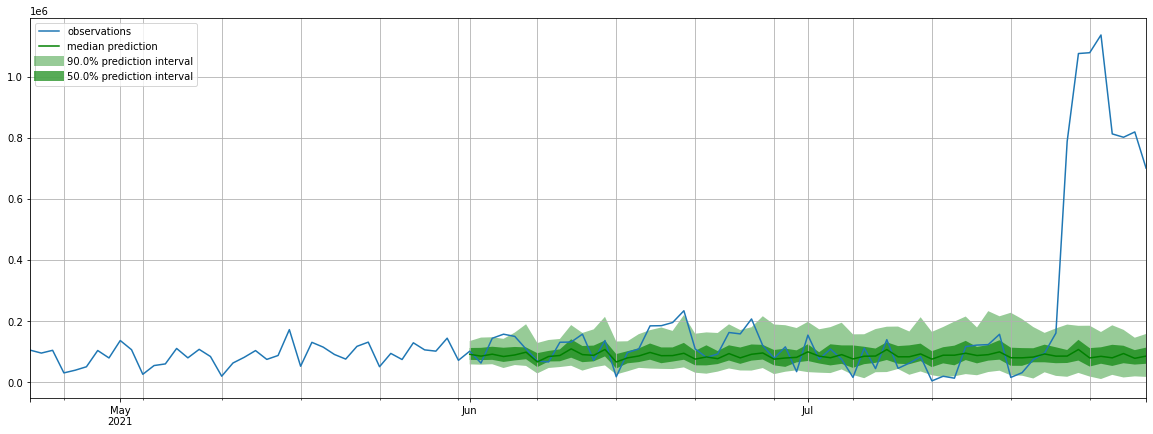

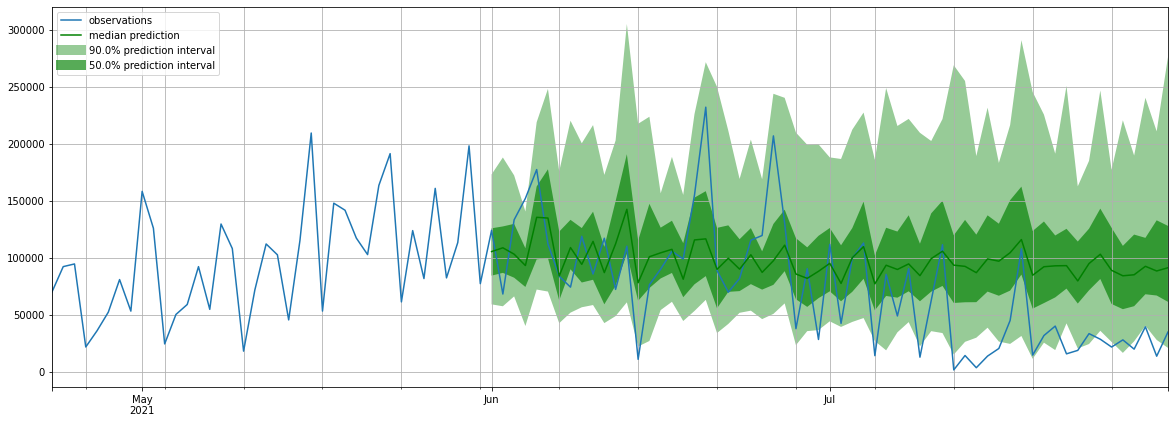

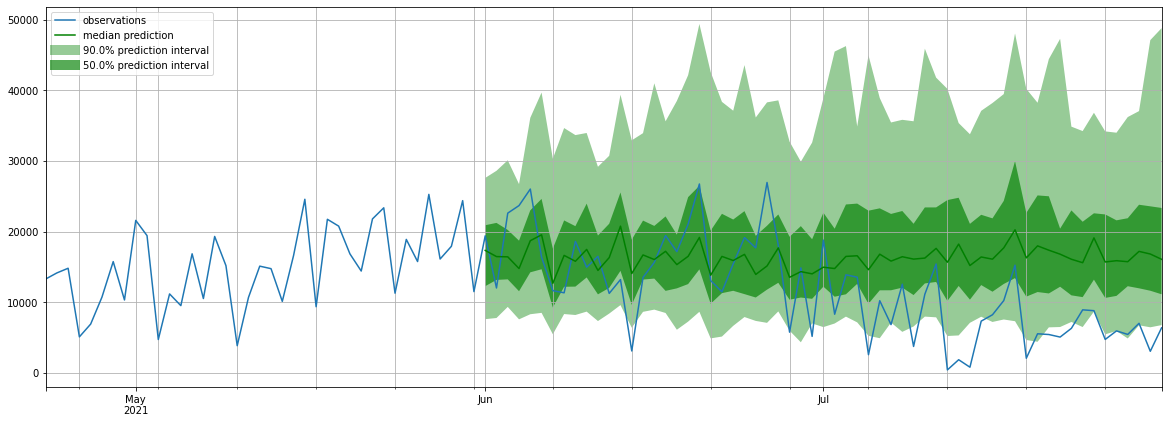

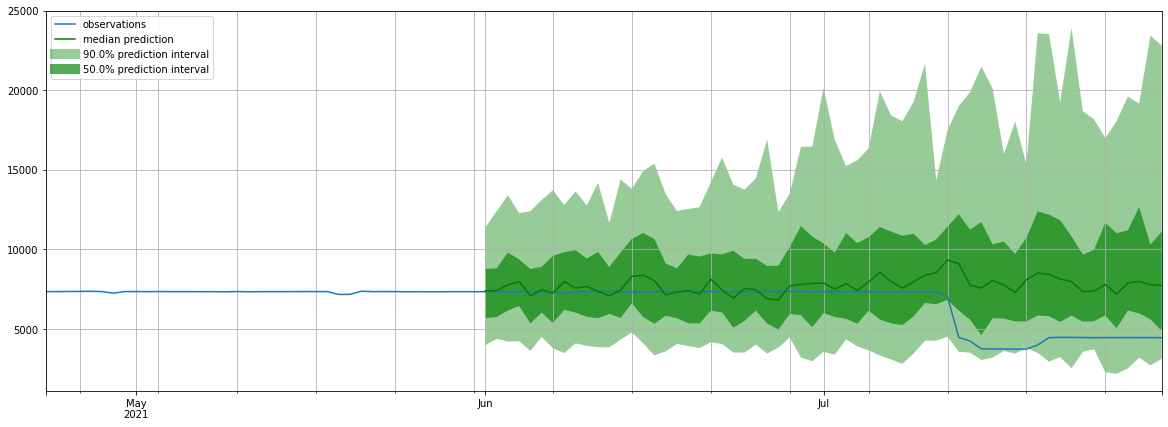

100%|██████████| 90/90 [00:18<00:00,  4.76it/s, epoch=10/10, avg_epoch_loss=6.56]


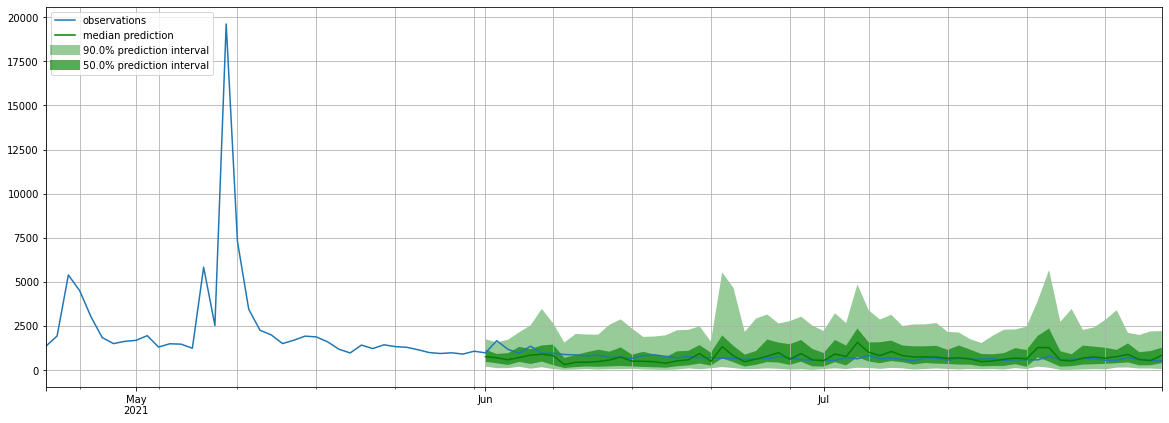

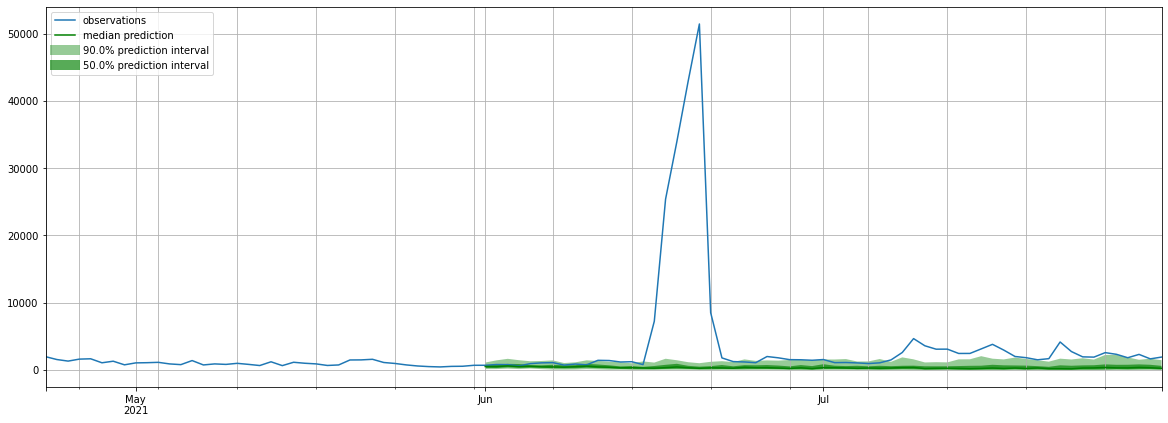

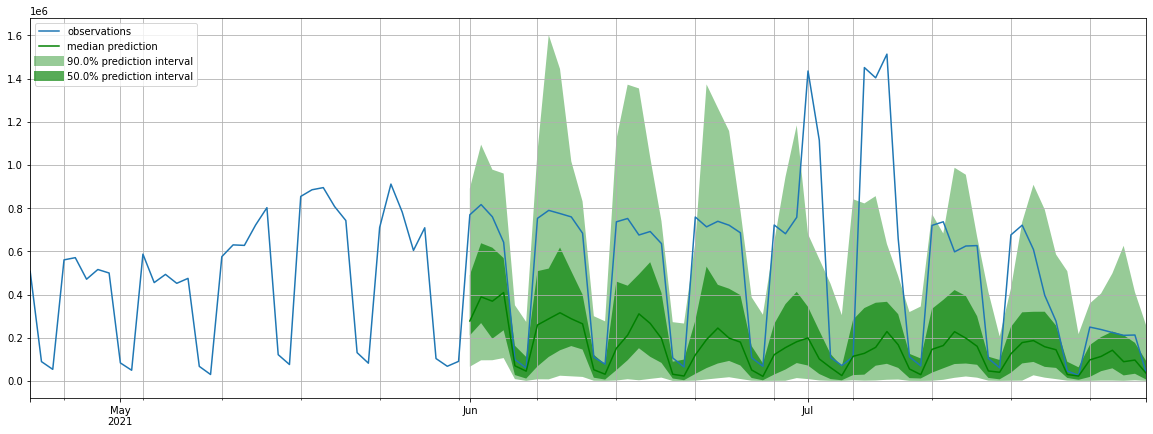

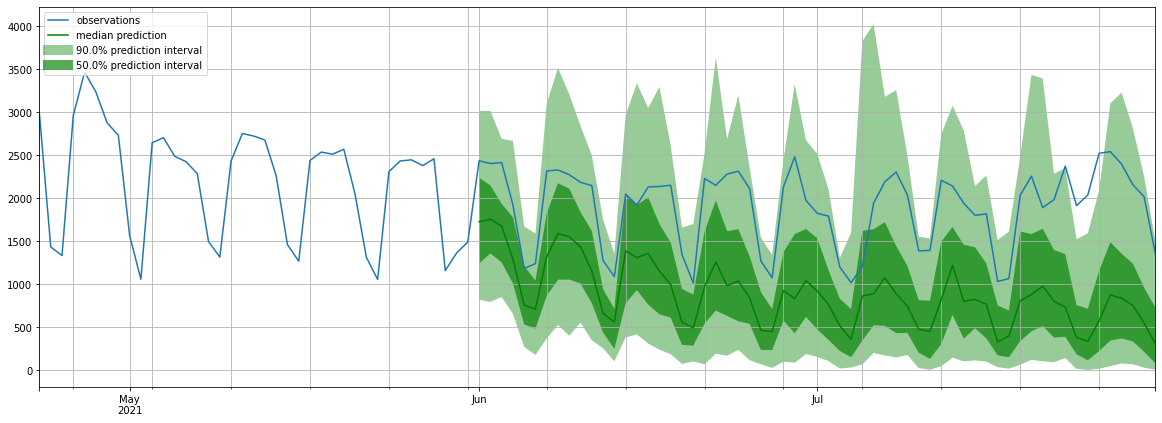

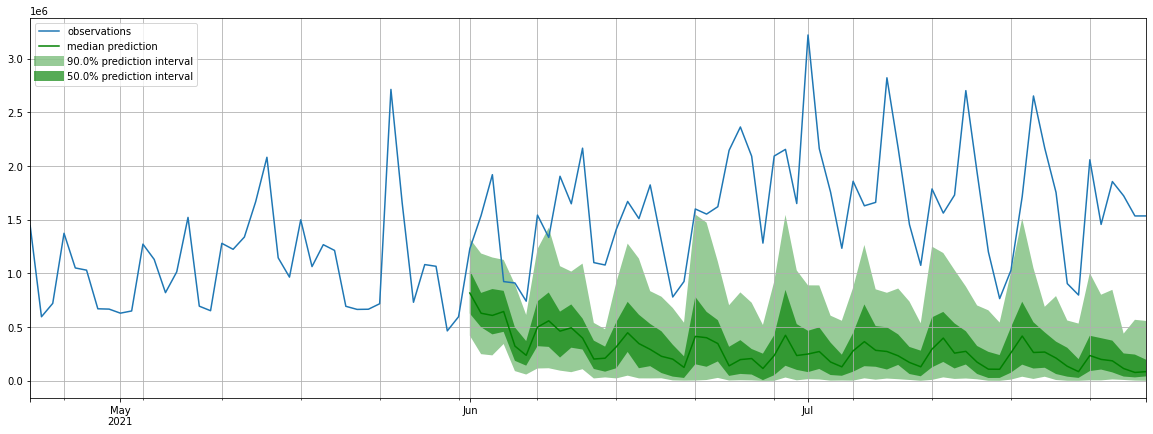

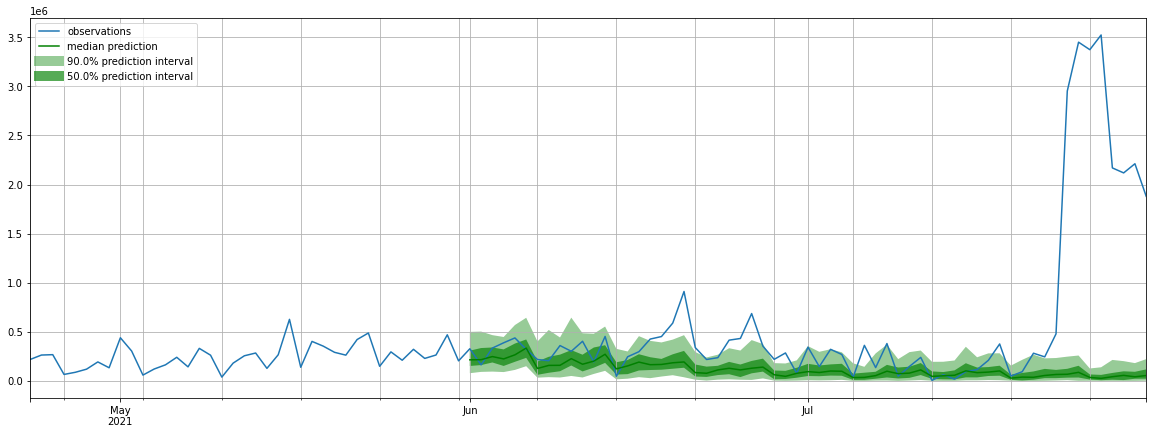

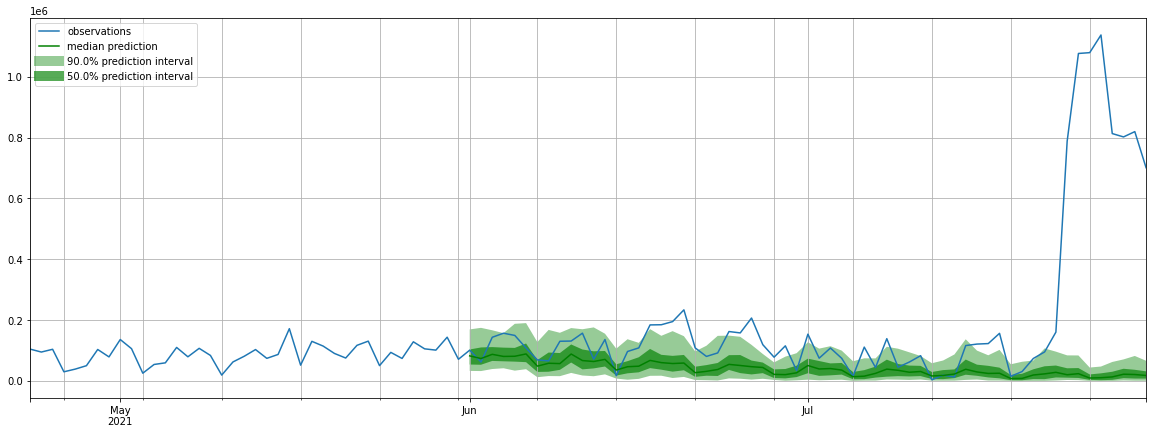

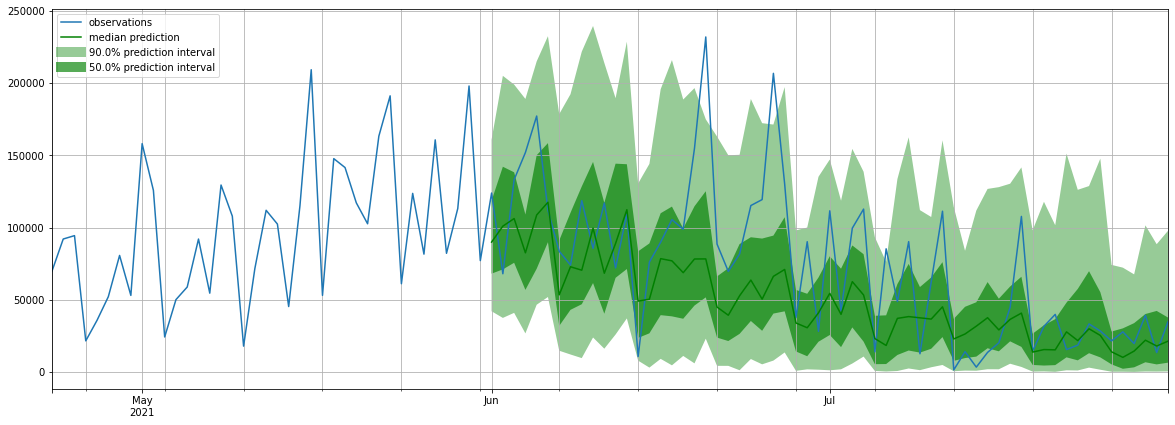

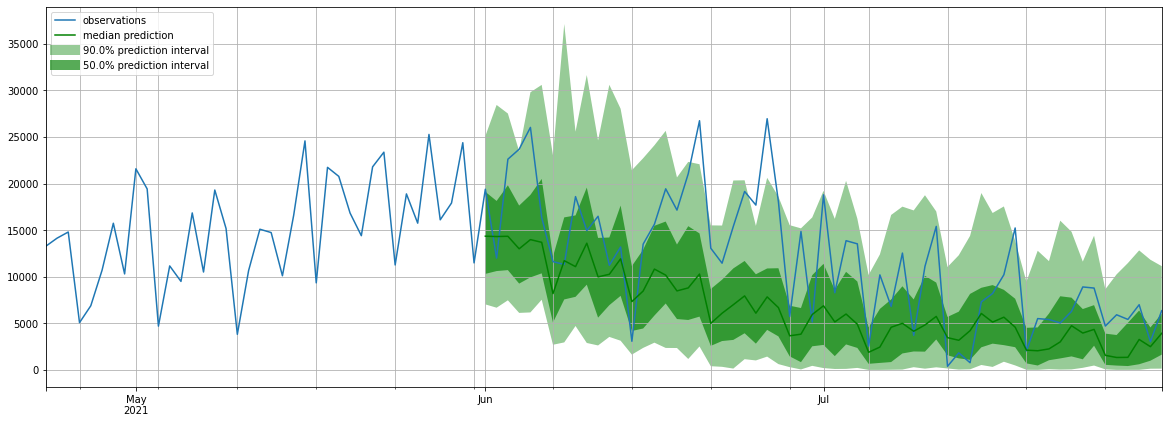

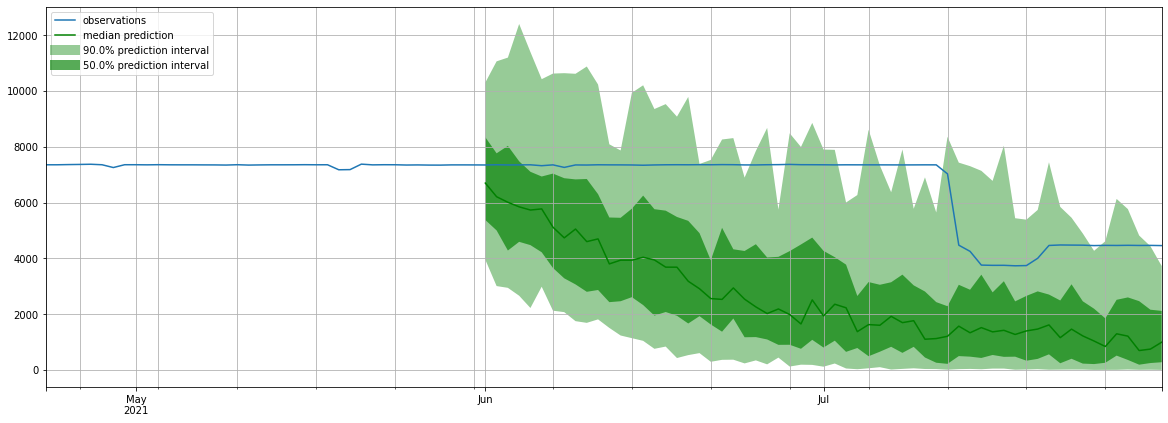

100%|██████████| 90/90 [00:19<00:00,  4.64it/s, epoch=10/10, avg_epoch_loss=10.2]


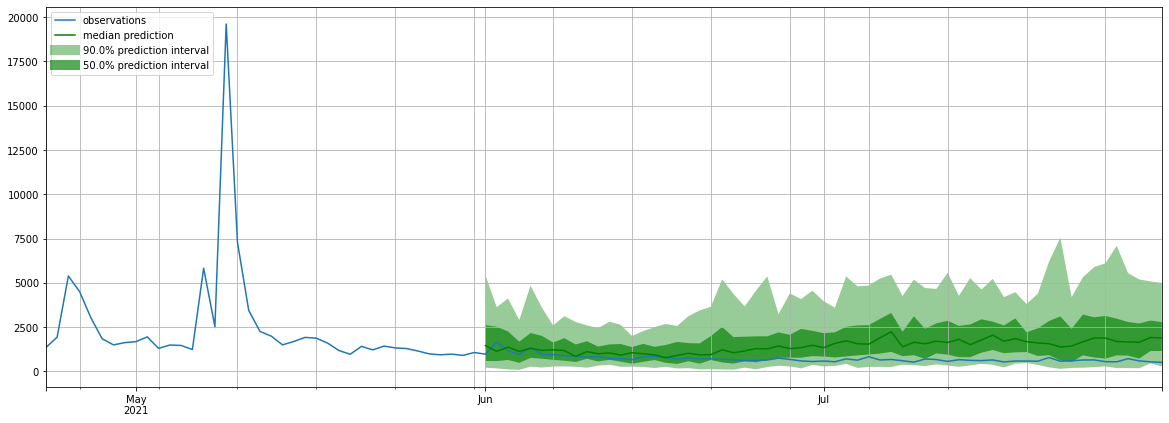

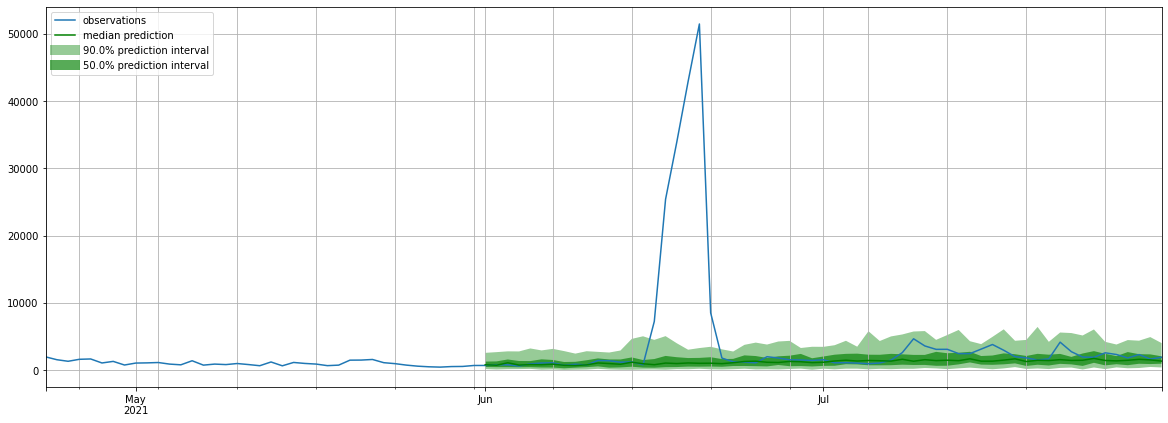

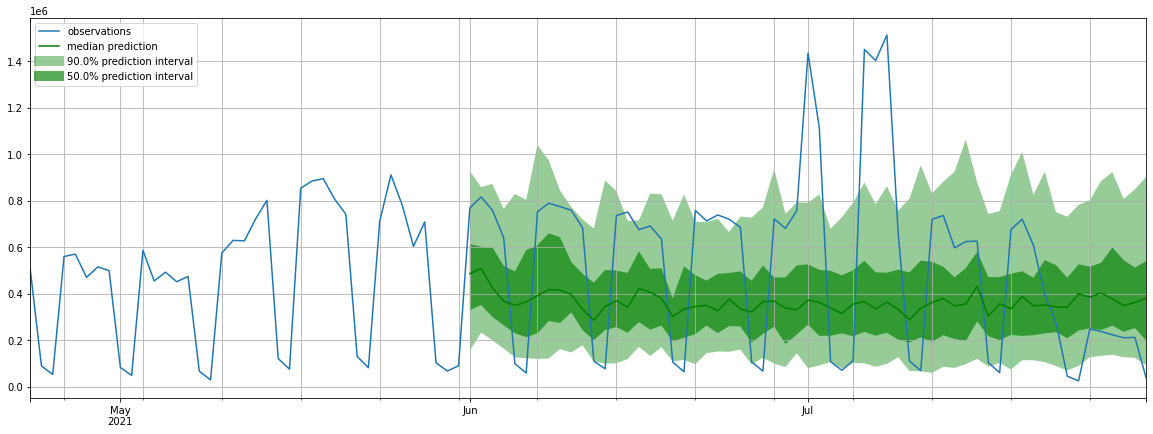

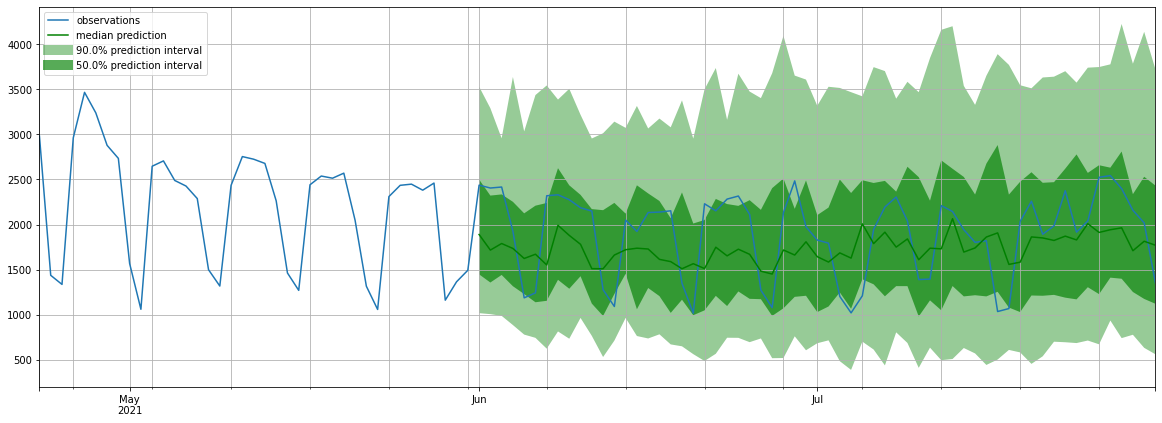

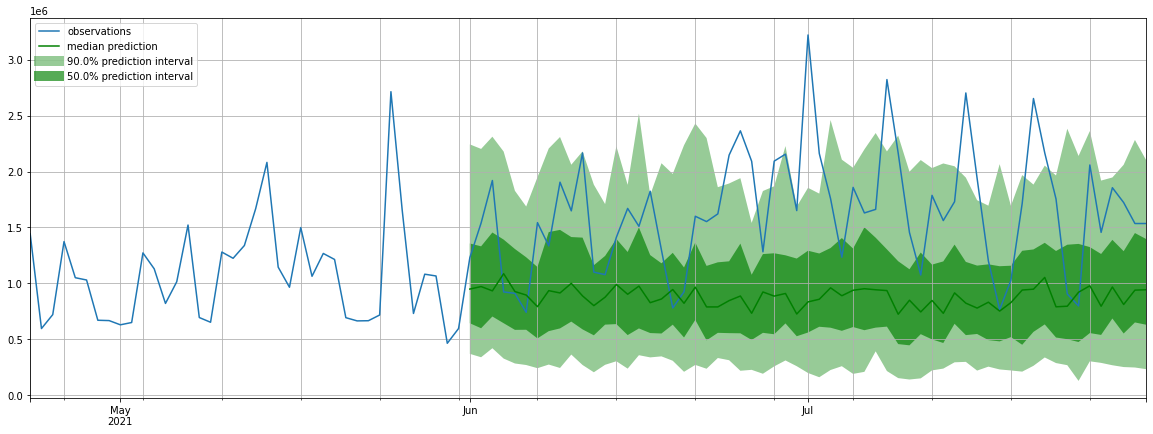

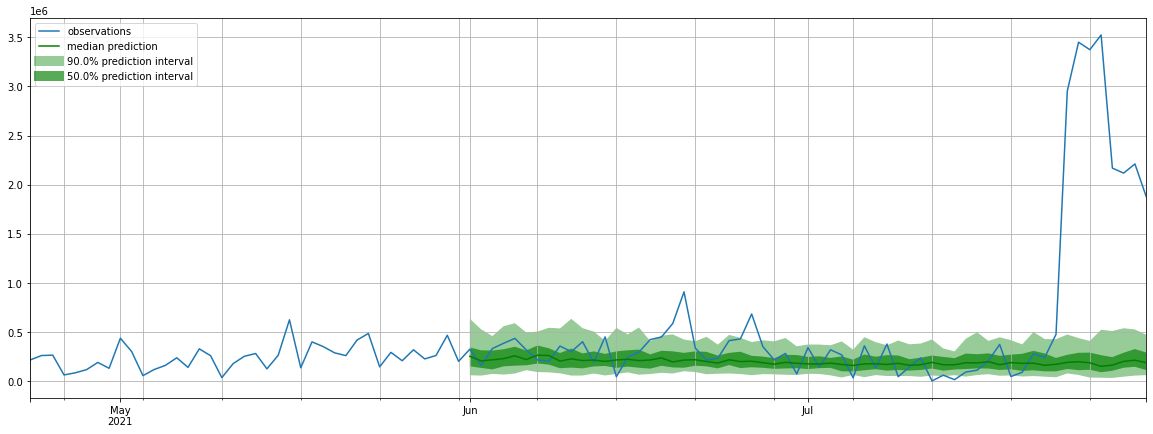

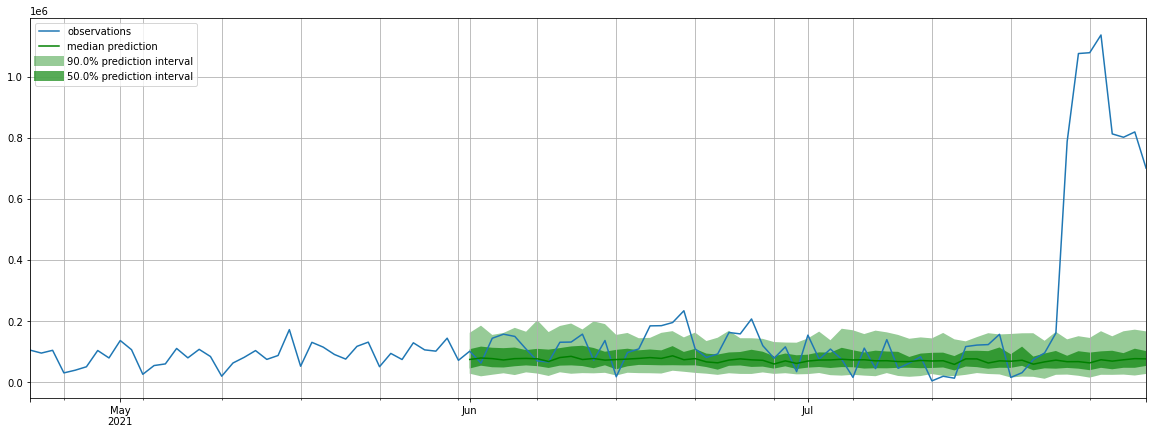

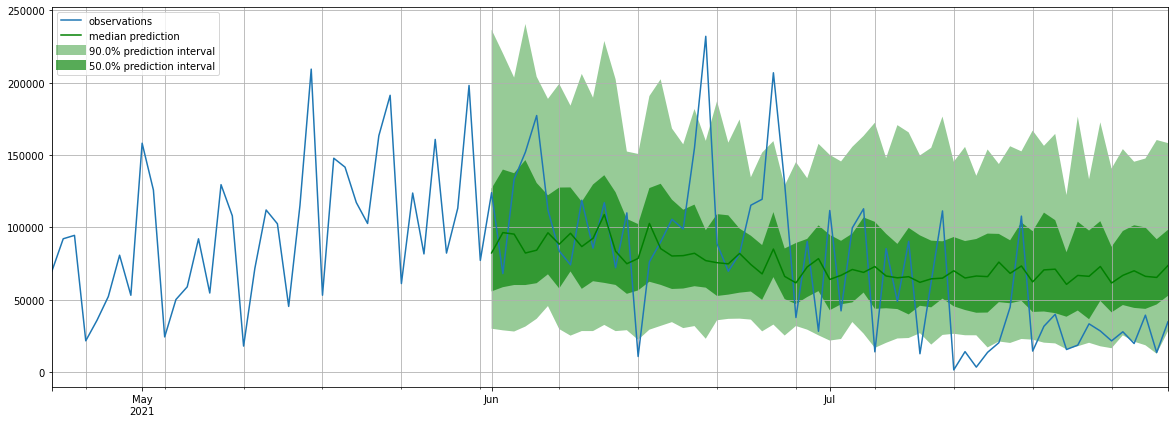

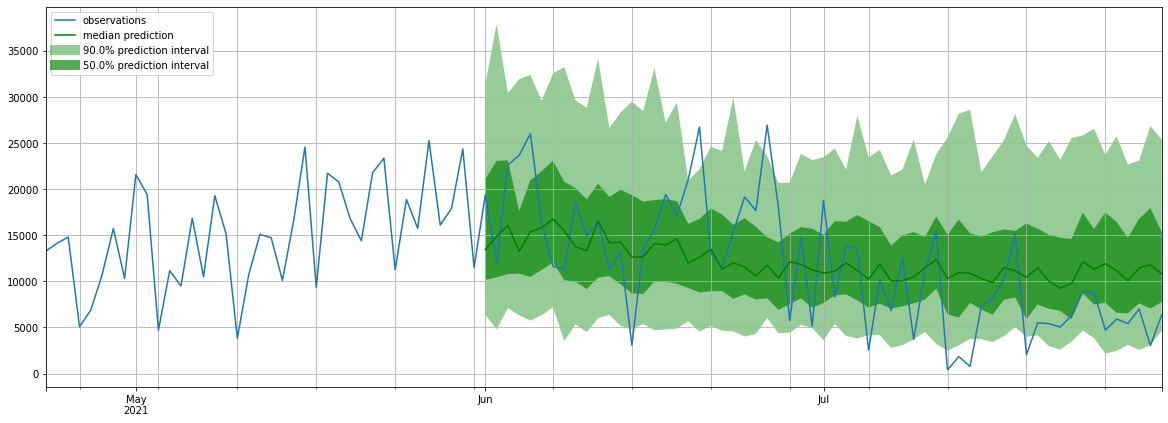

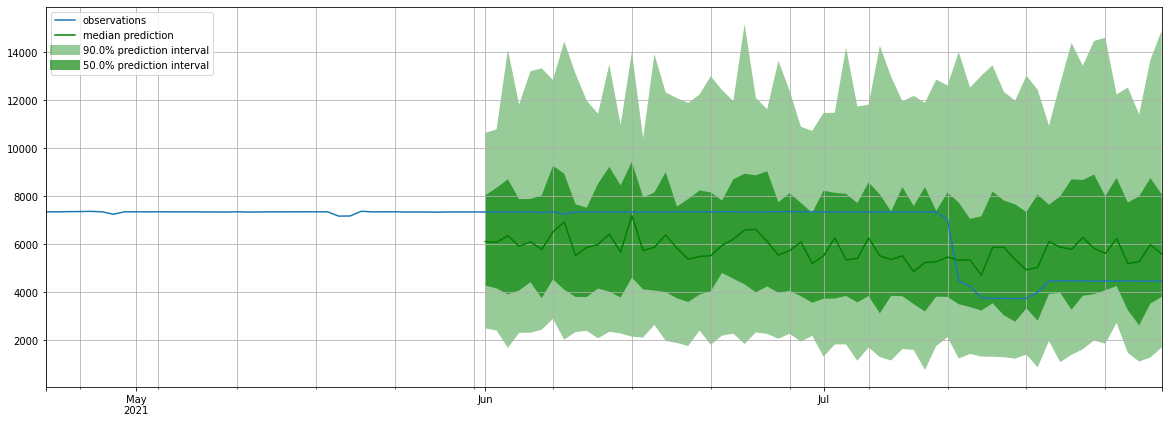

Running evaluation: 100%|██████████| 505/505 [00:00<00:00, 5832.67it/s]


In [24]:


from mxnet import gpu

agg_results = []
item_results = []
forecast_results = []
look_back = 1
for lr in [0.01, 0.001, 0.0001]:
    deepAR_estimator = DeepAREstimator(
        prediction_length=ds_meta['prediction_length'],
        context_length=ds_meta['prediction_length']*look_back,
        freq=ds_meta['freq'],
        num_layers=5,
        num_cells=90,
        distr_output = NegativeBinomialOutput(),
        use_feat_dynamic_real=True,
        use_feat_static_cat=False,
    #    cardinality=stat_cat_cardinalities,
        dropout_rate=0.1,
    #    cell_type='lstm',
        trainer=Trainer(   
            ctx=gpu(0),
            learning_rate=lr,
            epochs=10,
            num_batches_per_epoch=90,
            batch_size=128
        )
    )
    deepAR_predictor = deepAR_estimator.train(training_data=train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=deepAR_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    forecast_results.append(forecasts)
    tss = list(ts_it)
    for i in range(10):
        plot_prob_forecasts(tss[i], forecasts[i], plot_length=100, prediction_intervals = (50.0, 90.0))
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    agg_results.append(agg_metrics)
    item_results.append(item_metrics)

In [25]:
for a in agg_results:
    print(json.dumps(a, indent=4))
    print('======================================================')

{
    "MSE": 337913760362.95605,
    "abs_error": 2232582896.0,
    "abs_target_sum": 7704185253.0,
    "abs_target_mean": 250095.28495374127,
    "seasonal_error": 28550.678706690196,
    "MASE": 80.89057632970878,
    "MAPE": 19.16662982190069,
    "sMAPE": 0.6254086912080952,
    "MSIS": 3044.2234316630206,
    "QuantileLoss[0.1]": 1084873032.6,
    "Coverage[0.1]": 0.08966076935562409,
    "QuantileLoss[0.5]": 2232582870.0,
    "Coverage[0.5]": 0.594935887031326,
    "QuantileLoss[0.9]": 1967315750.6,
    "Coverage[0.9]": 0.9172536925823731,
    "RMSE": 581303.5010757771,
    "NRMSE": 2.324328110317224,
    "ND": 0.2897883192944556,
    "wQuantileLoss[0.1]": 0.14081606256515597,
    "wQuantileLoss[0.5]": 0.28978831591966653,
    "wQuantileLoss[0.9]": 0.2553567555808617,
    "mean_absolute_QuantileLoss": 1761590551.0666666,
    "mean_wQuantileLoss": 0.22865371135522805,
    "MAE_Coverage": 0.04084293675269168,
    "OWA": NaN
}
{
    "MSE": 1421795007298.082,
    "abs_error": 5013931

In [26]:
mape = []
sids = selected_df['site_id'].to_list()
for f in forecast_results:
    for i in range(ds_meta['num_series']):
        fc_val = f[i].samples
        fc_mean = fc_val.mean(axis=0)
        display_df = nbcu_comp_test[nbcu_comp_test['site_id']==sids[i]].copy()
        display_df['p50'] = fc_mean
        display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
        mape.append(display_df['deviation'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarni

## Search by context_length

100%|██████████| 100/100 [00:21<00:00,  4.74it/s, epoch=10/10, avg_epoch_loss=7.38]


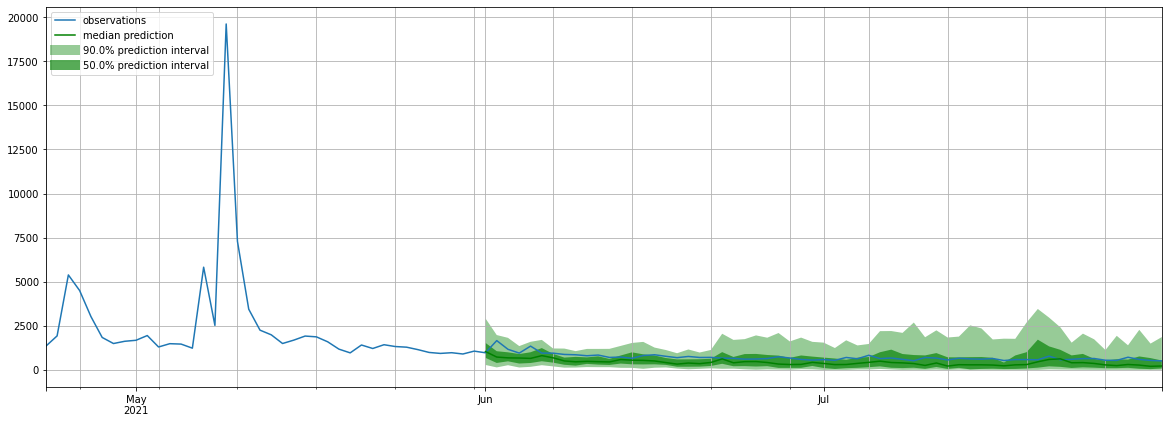

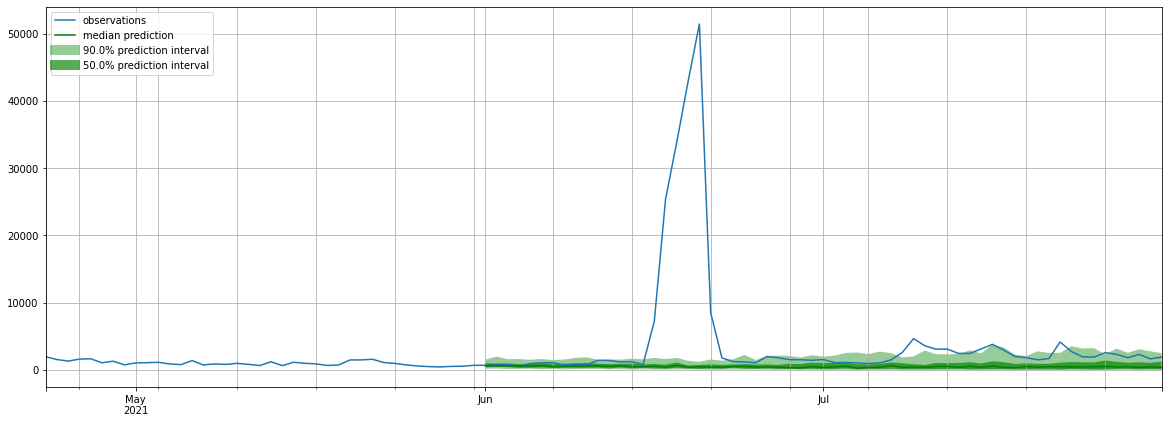

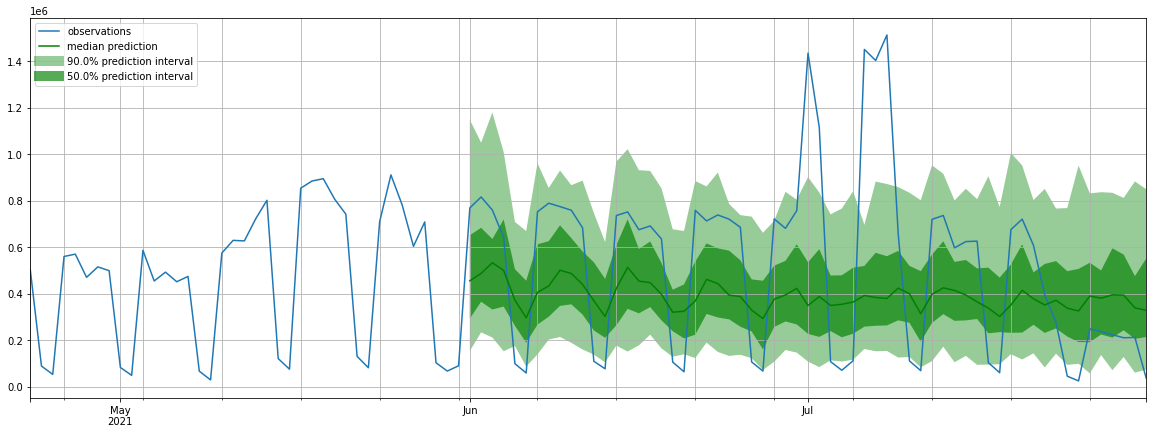

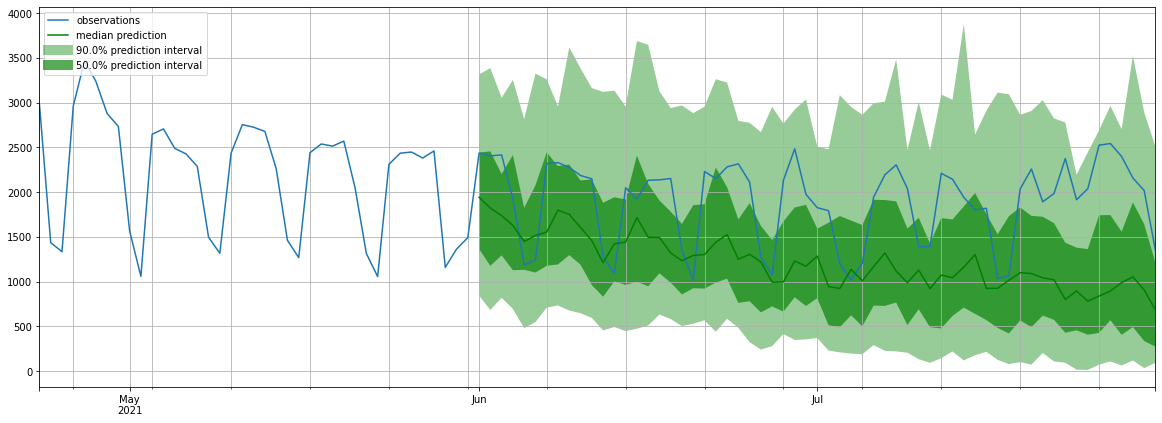

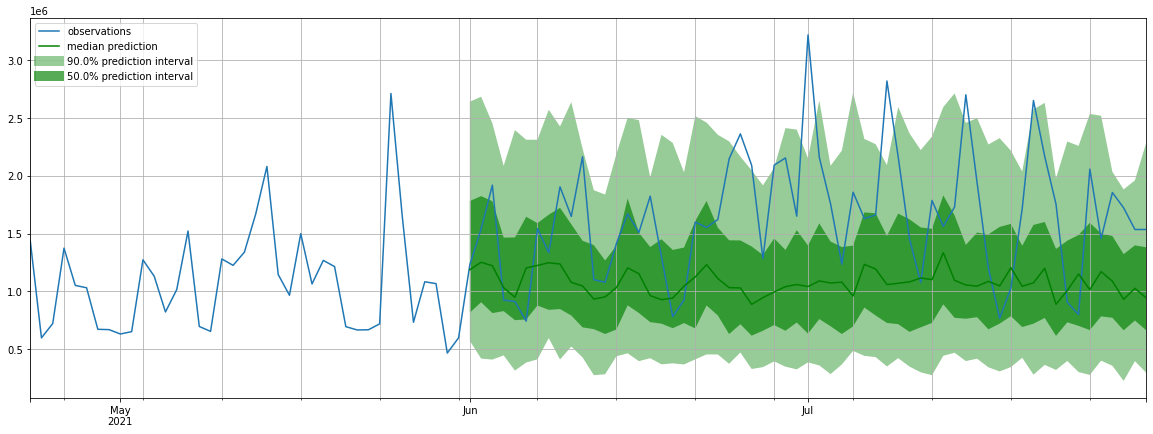

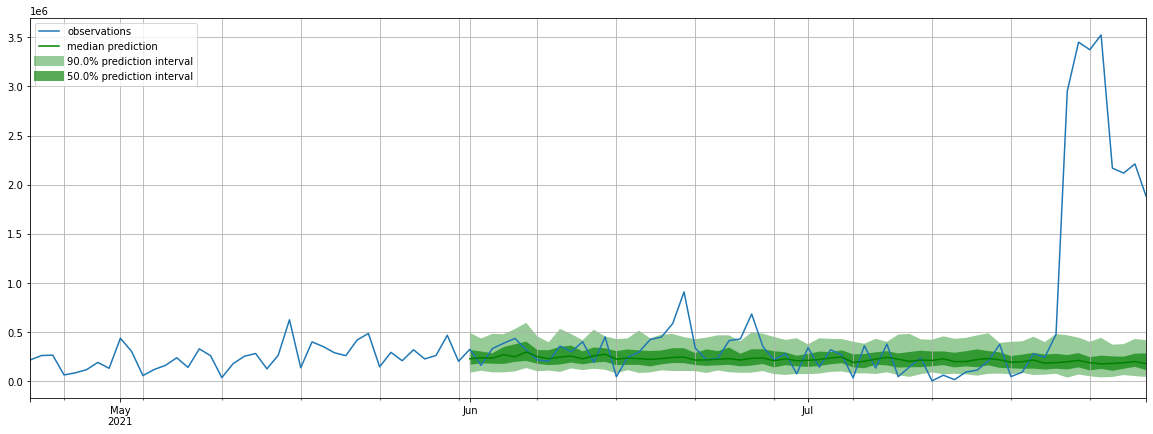

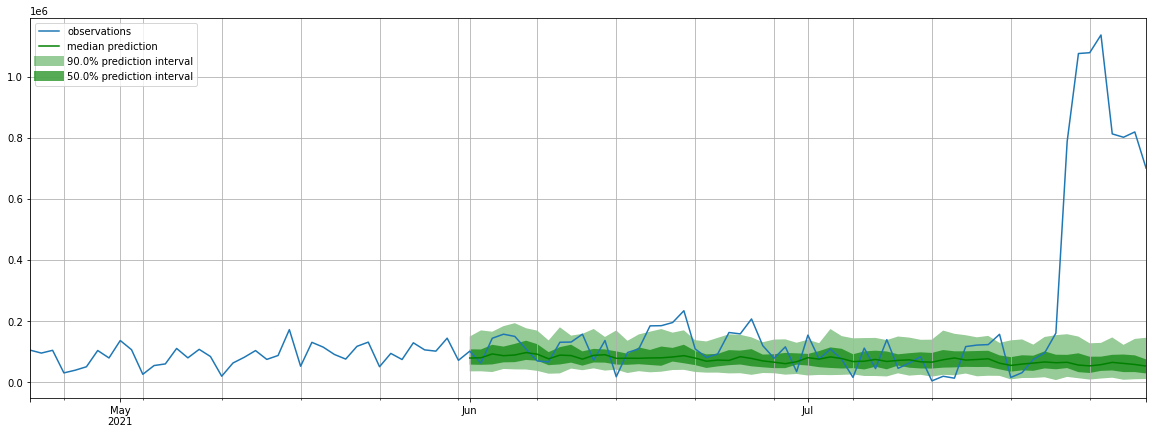

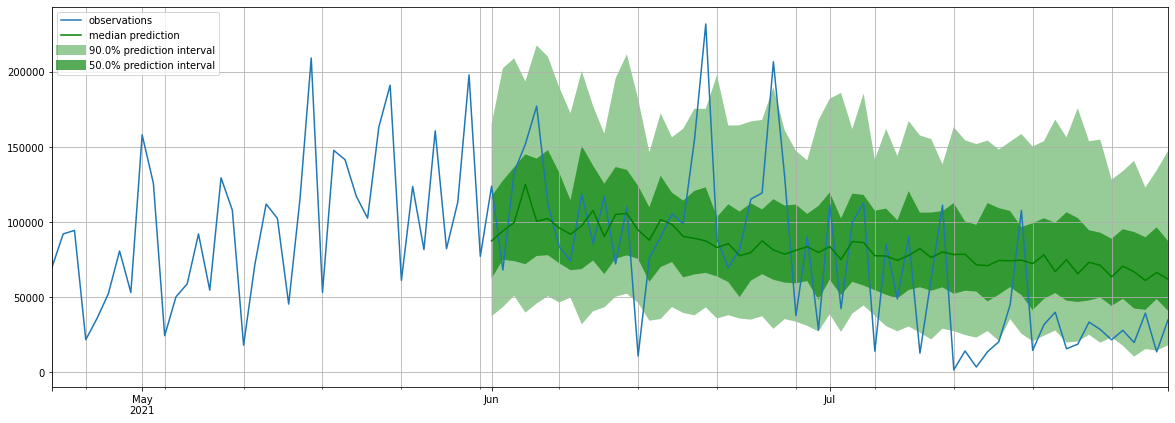

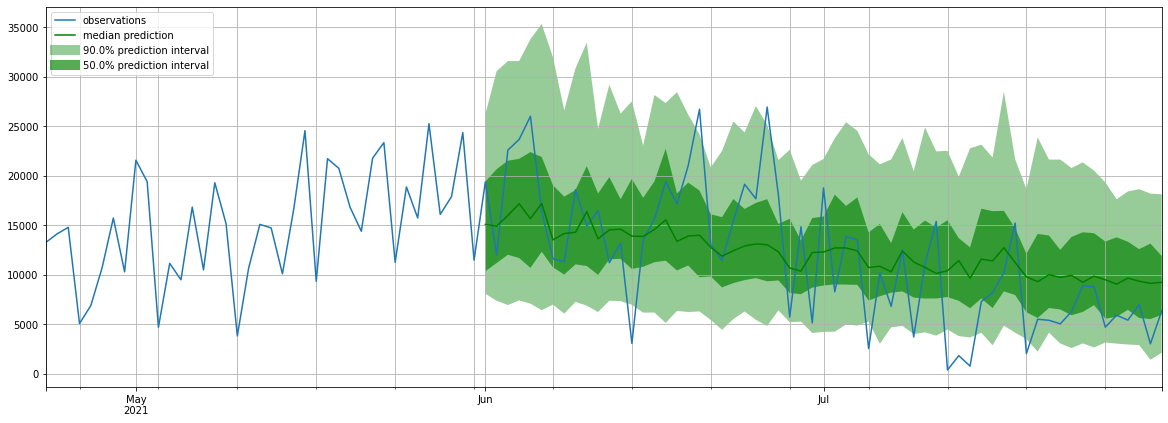

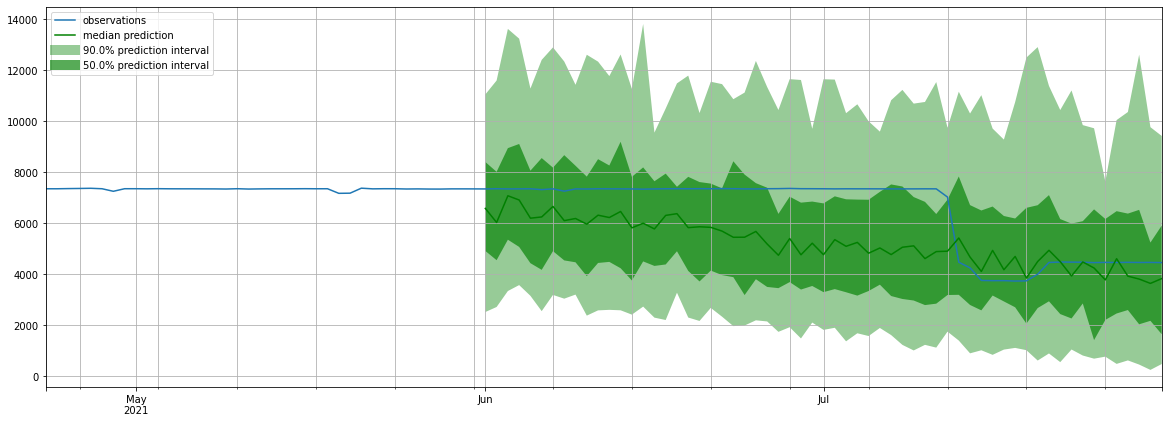

100%|██████████| 100/100 [00:29<00:00,  3.34it/s, epoch=10/10, avg_epoch_loss=7.16]


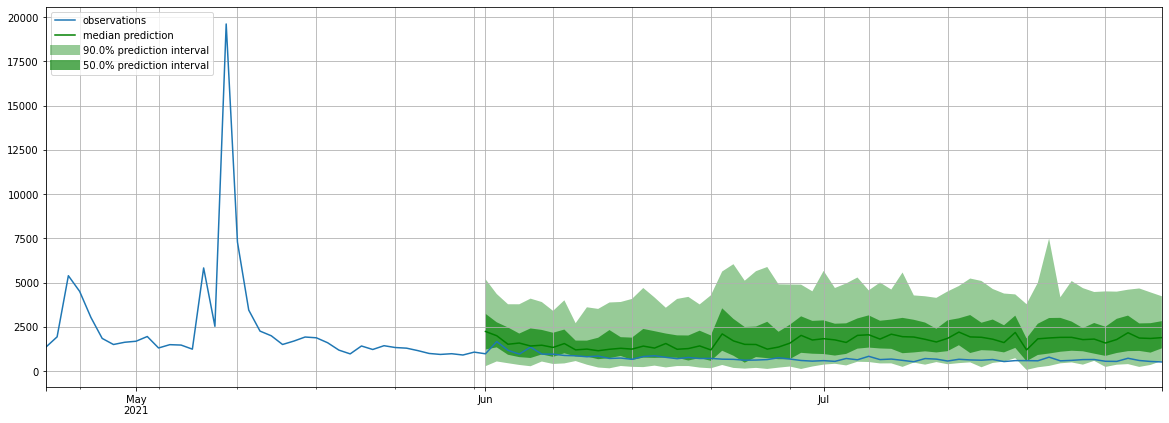

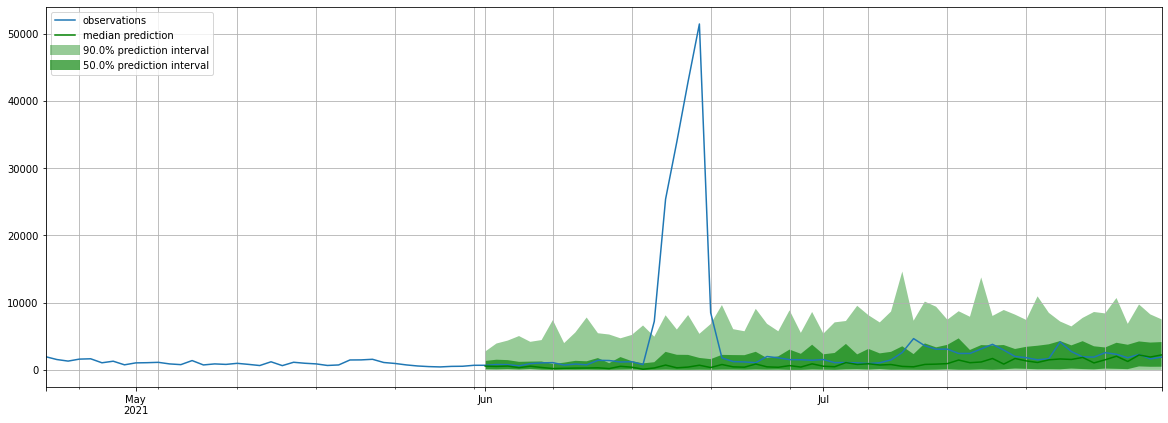

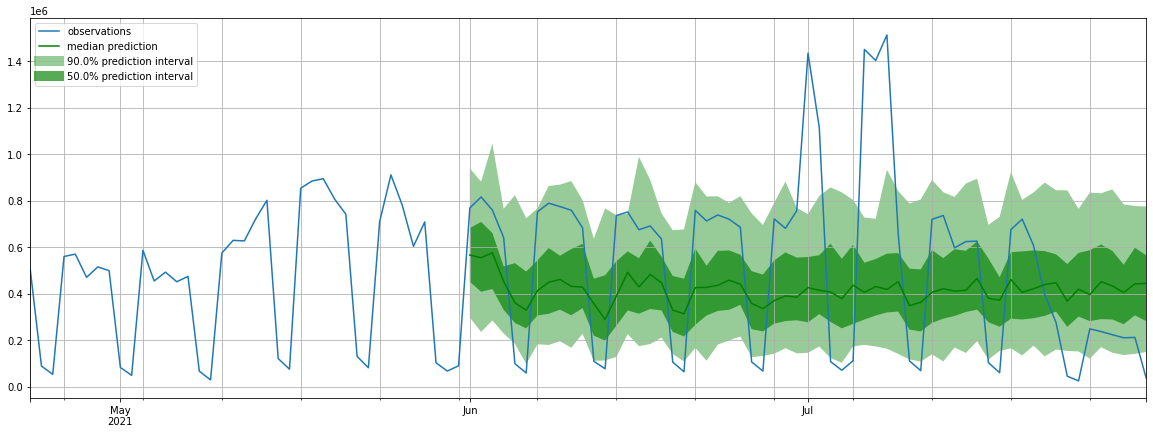

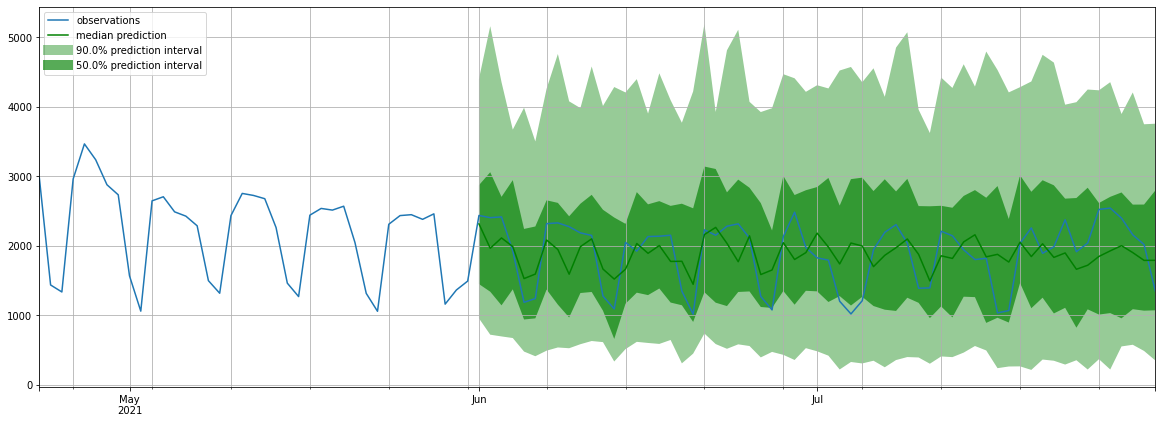

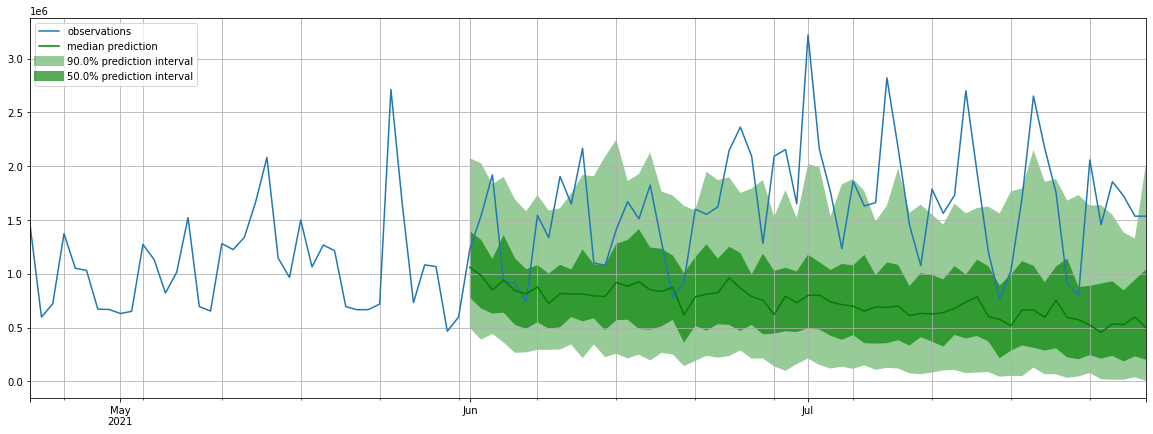

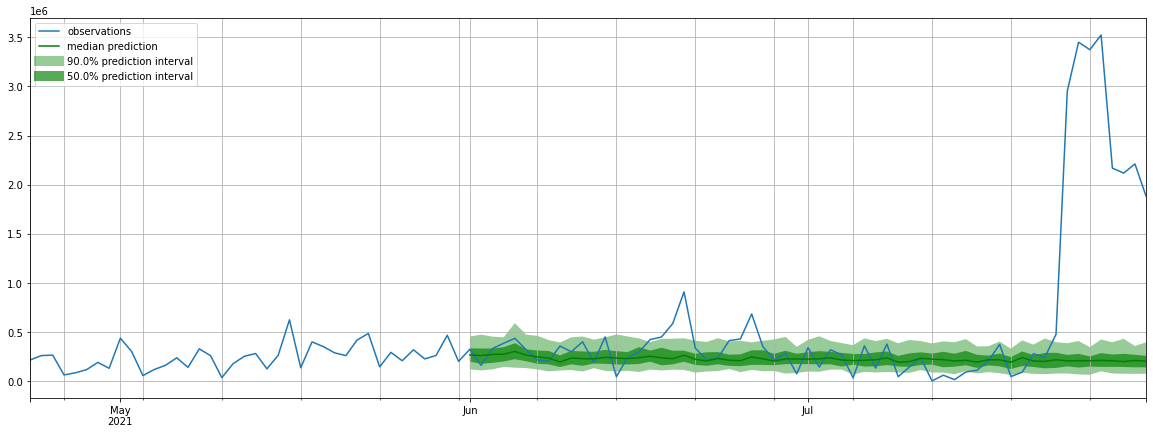

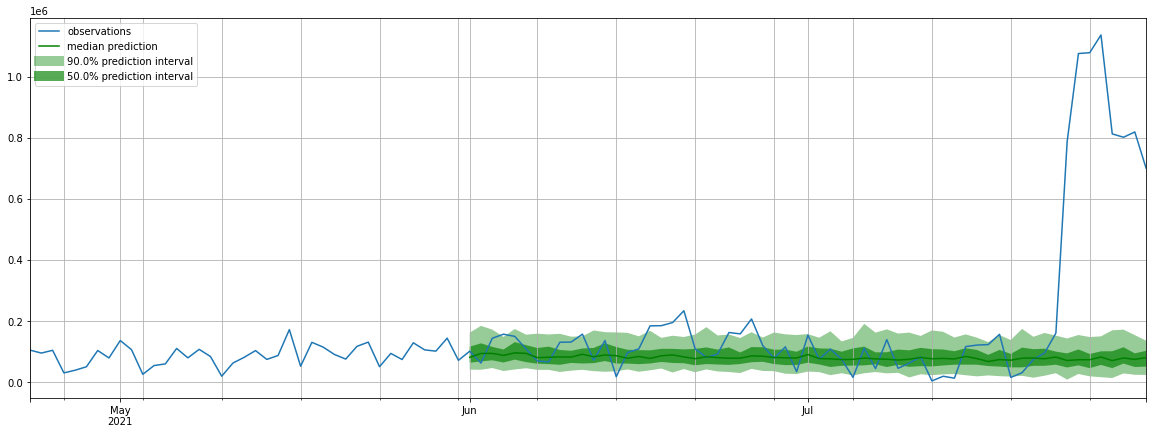

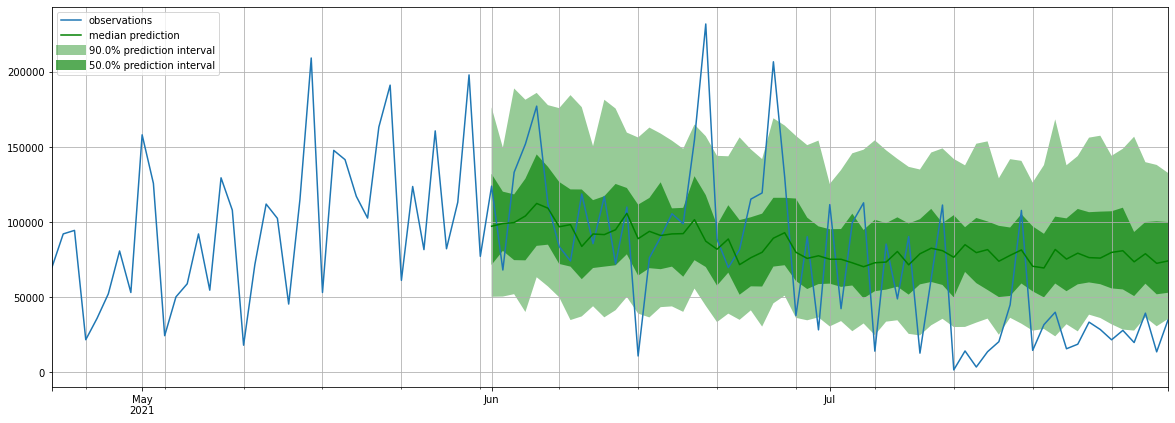

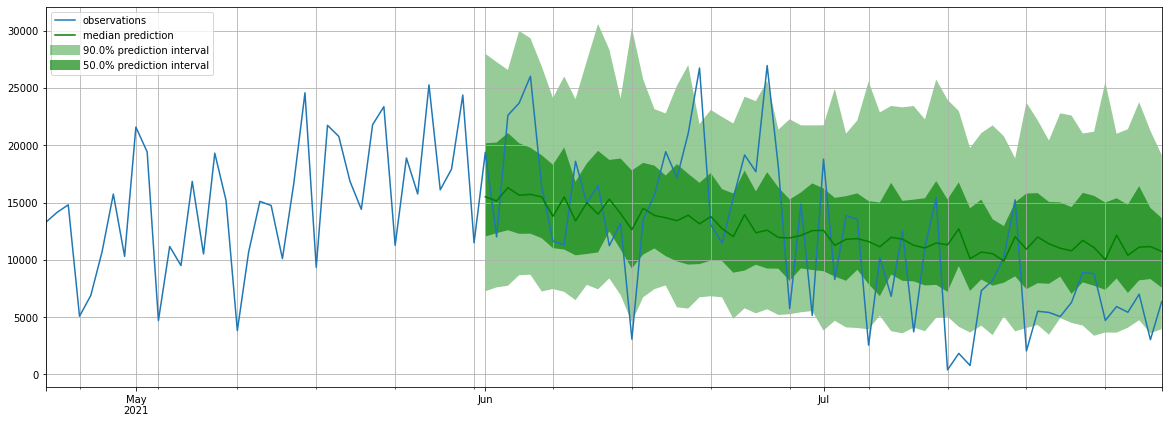

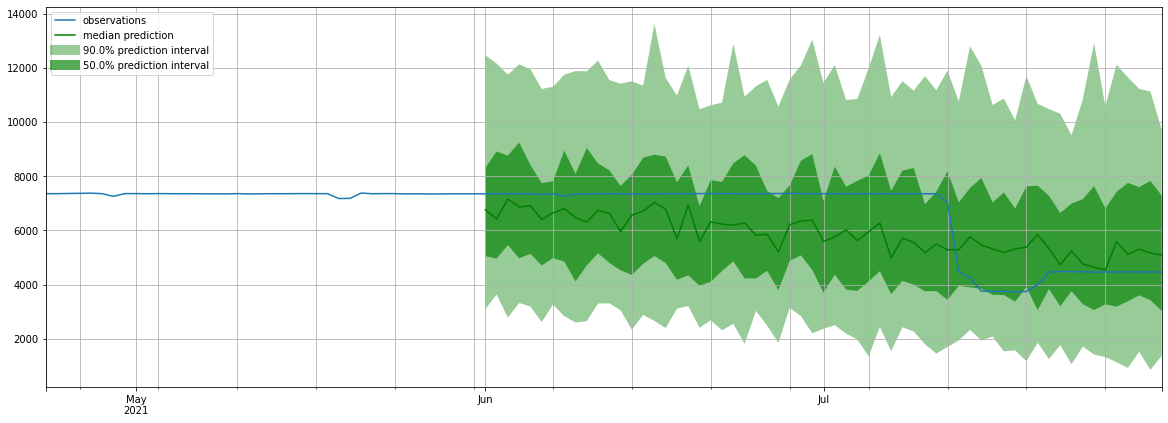

100%|██████████| 100/100 [00:38<00:00,  2.56it/s, epoch=10/10, avg_epoch_loss=9.05]


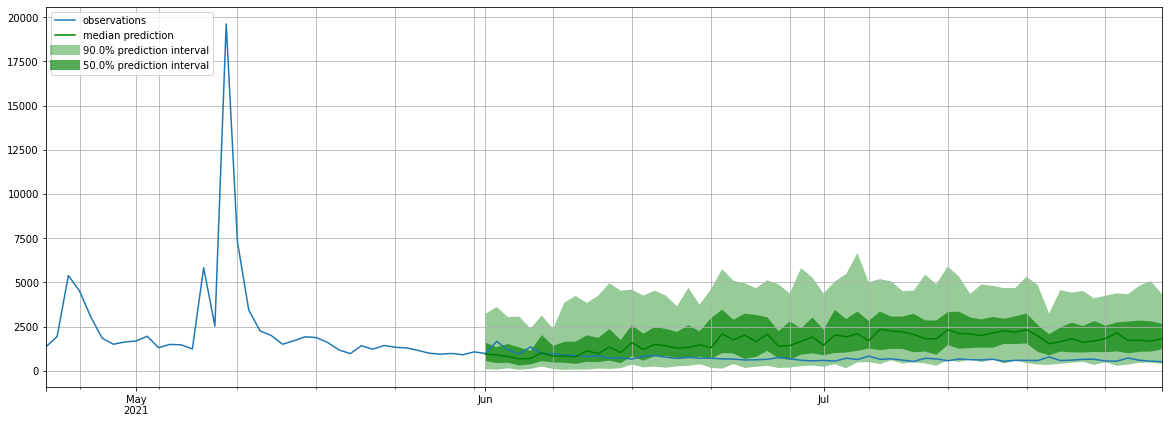

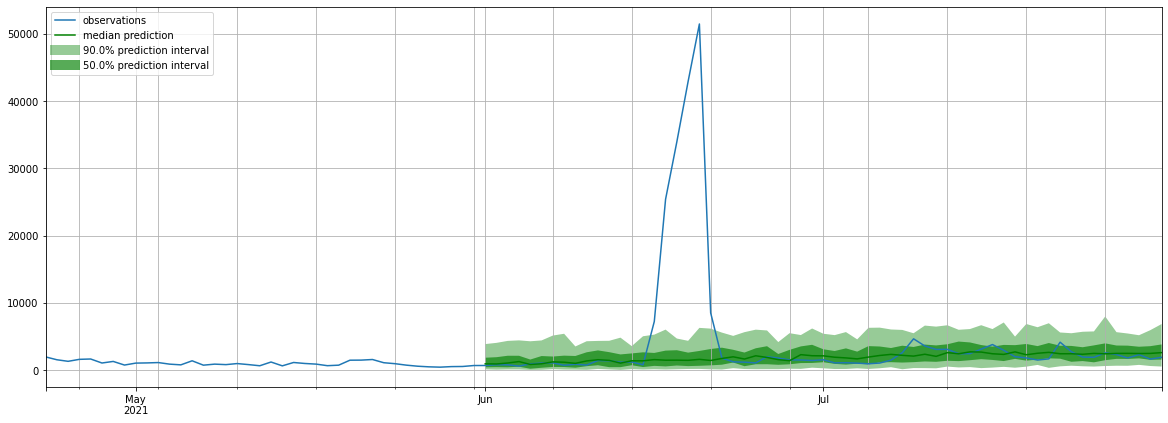

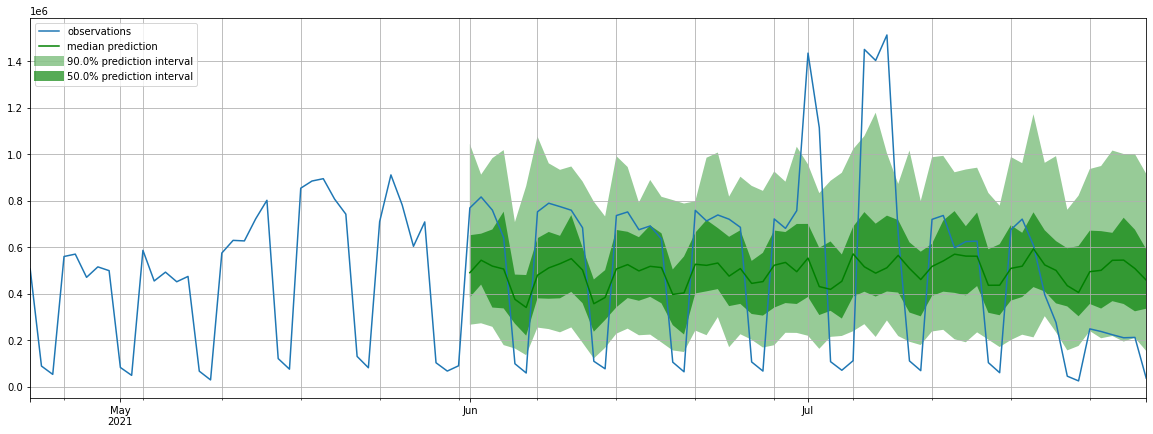

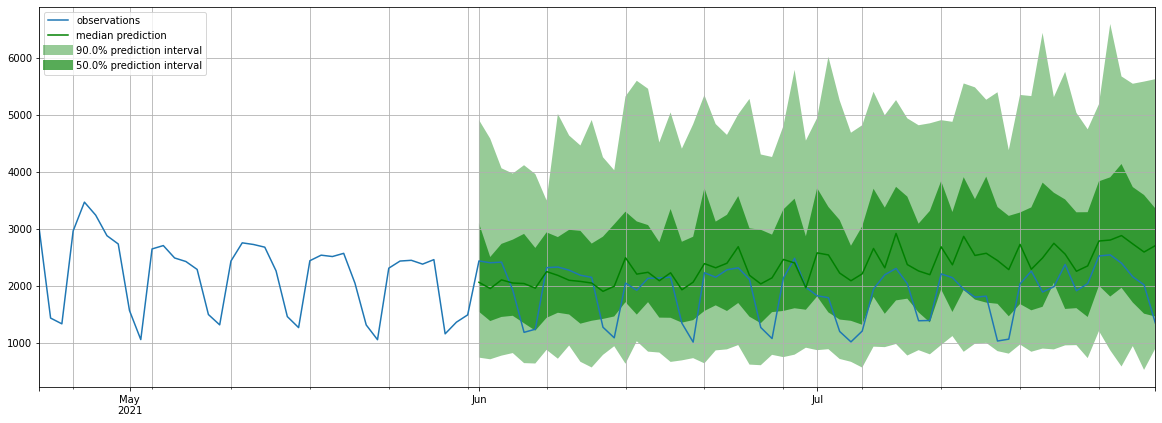

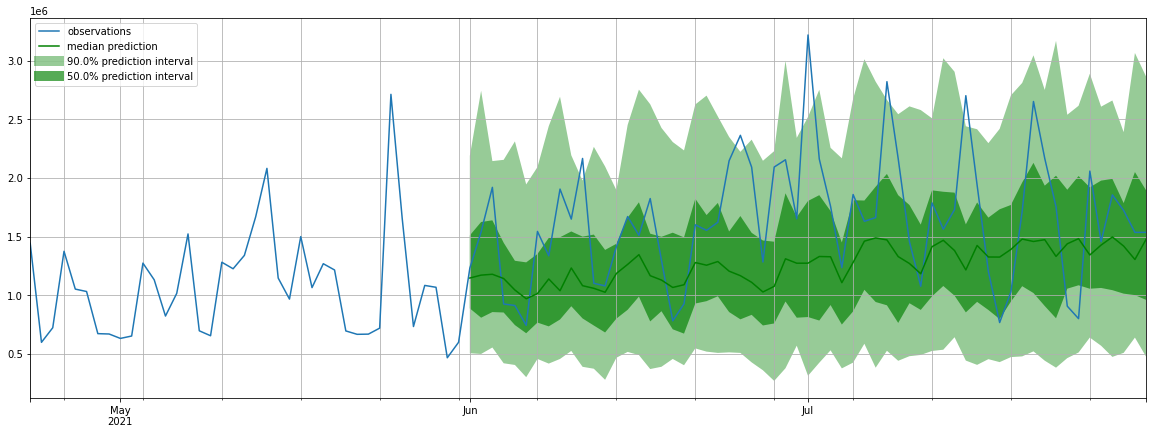

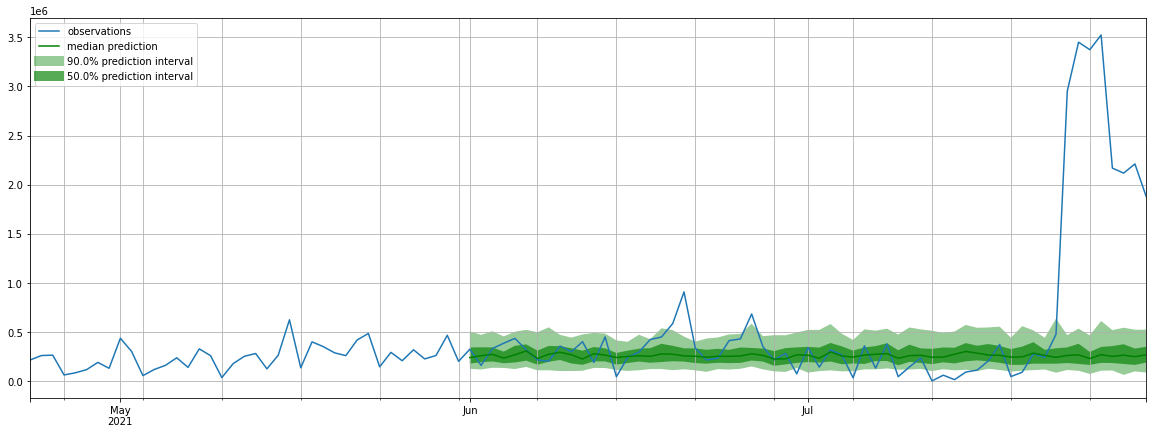

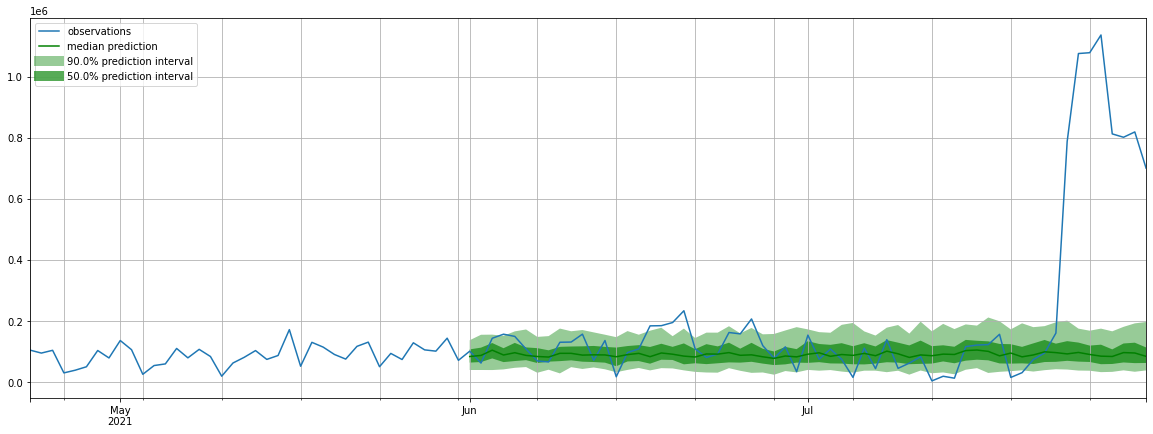

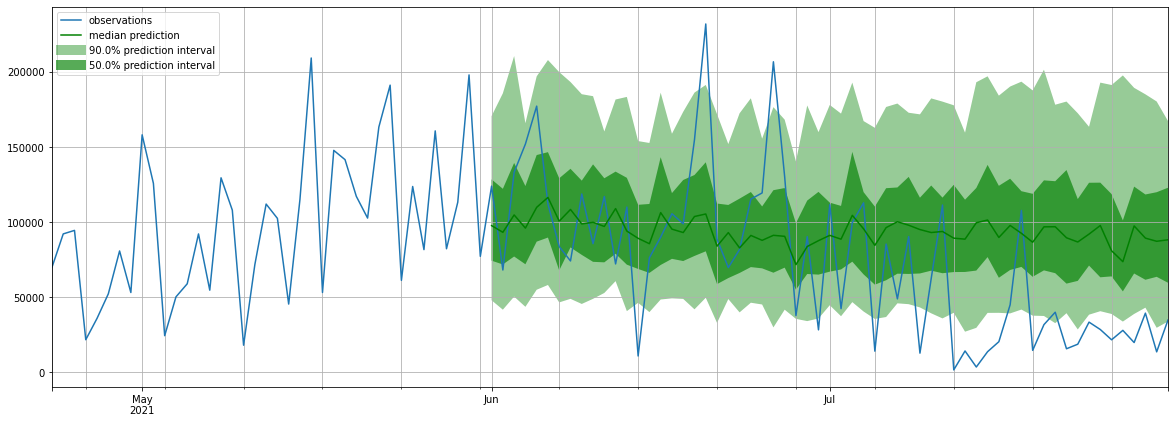

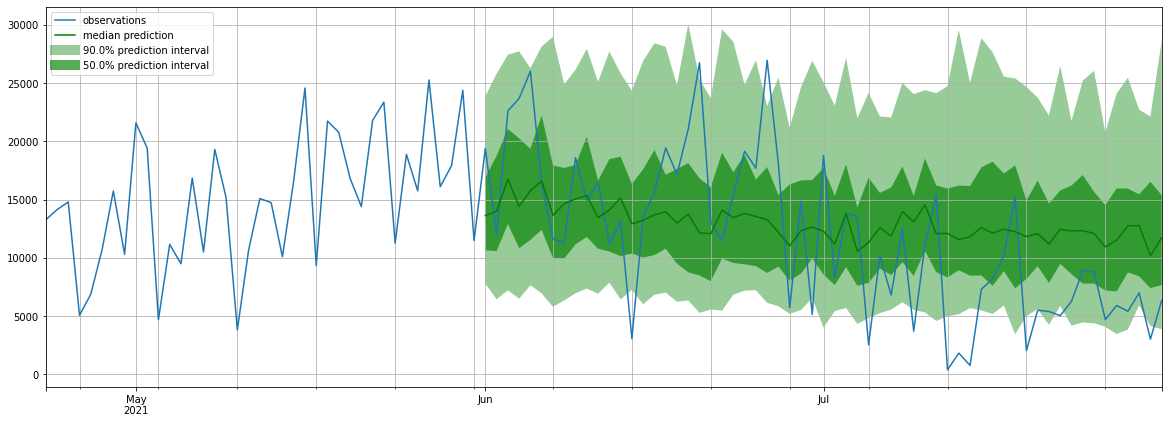

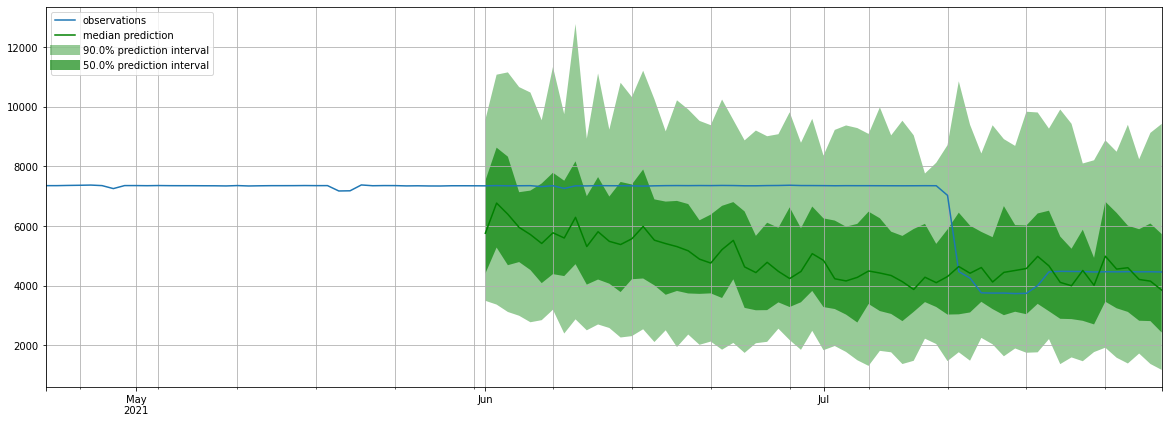

100%|██████████| 100/100 [00:47<00:00,  2.09it/s, epoch=10/10, avg_epoch_loss=7.77]


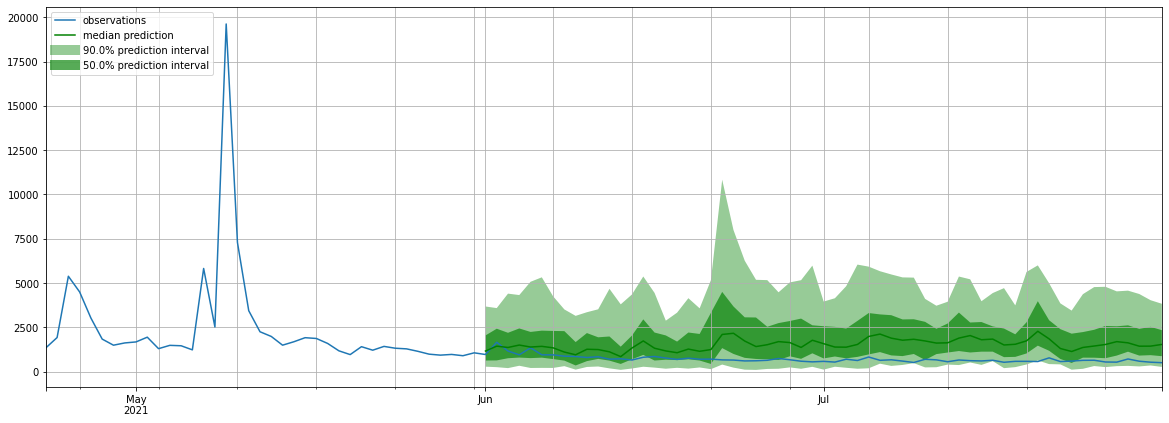

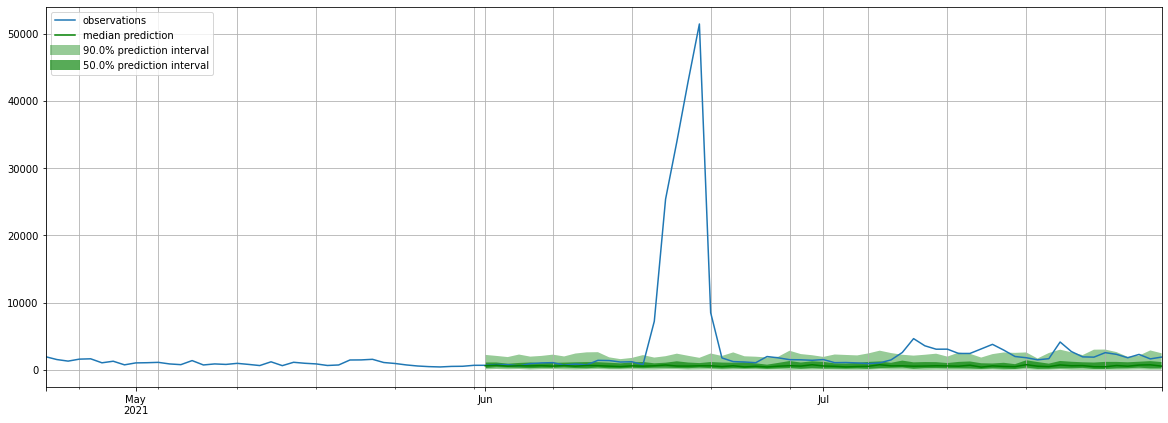

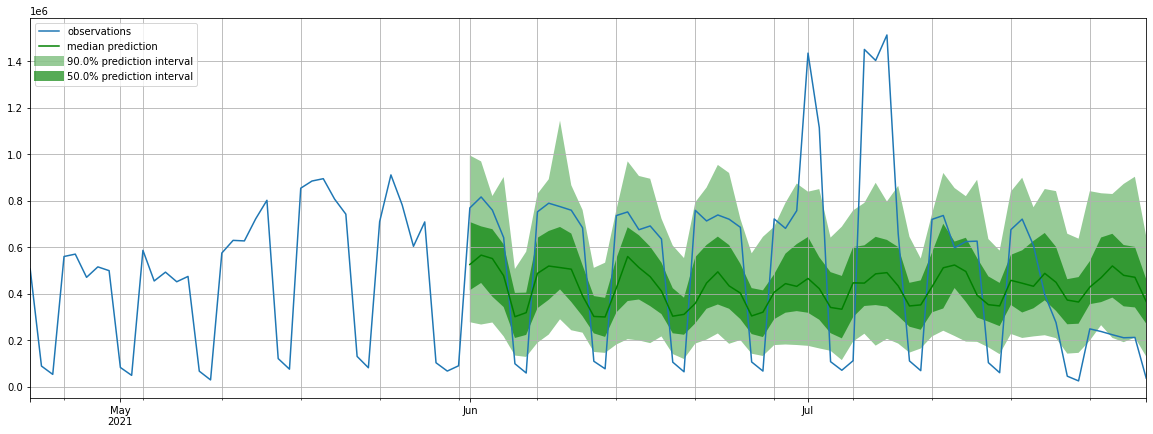

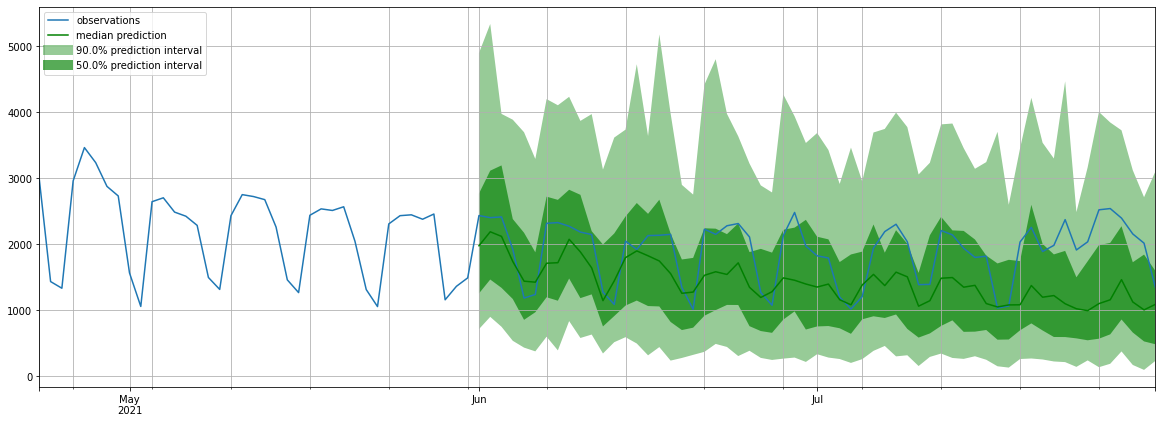

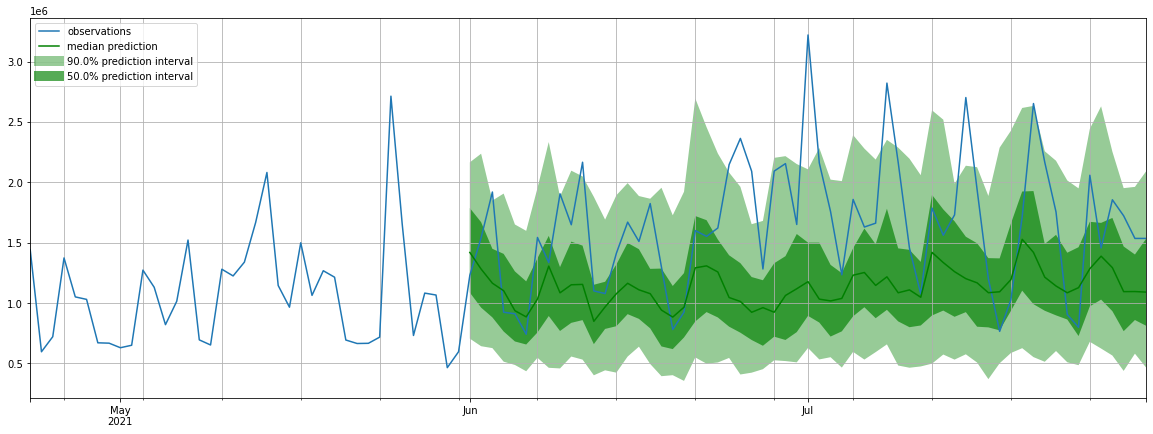

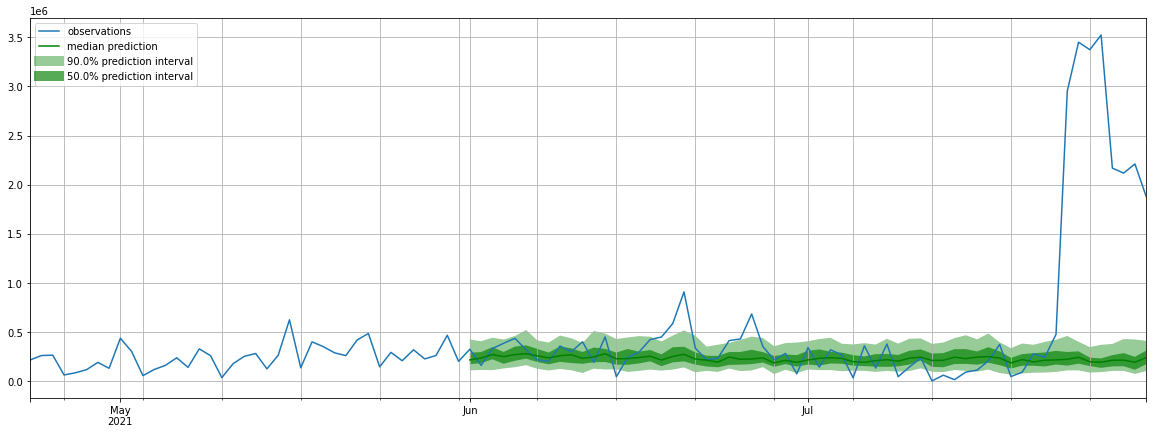

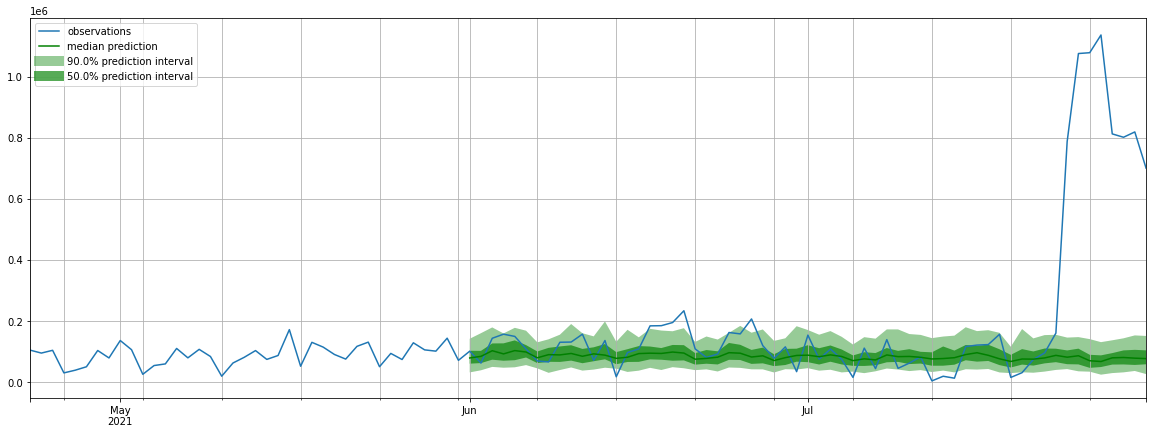

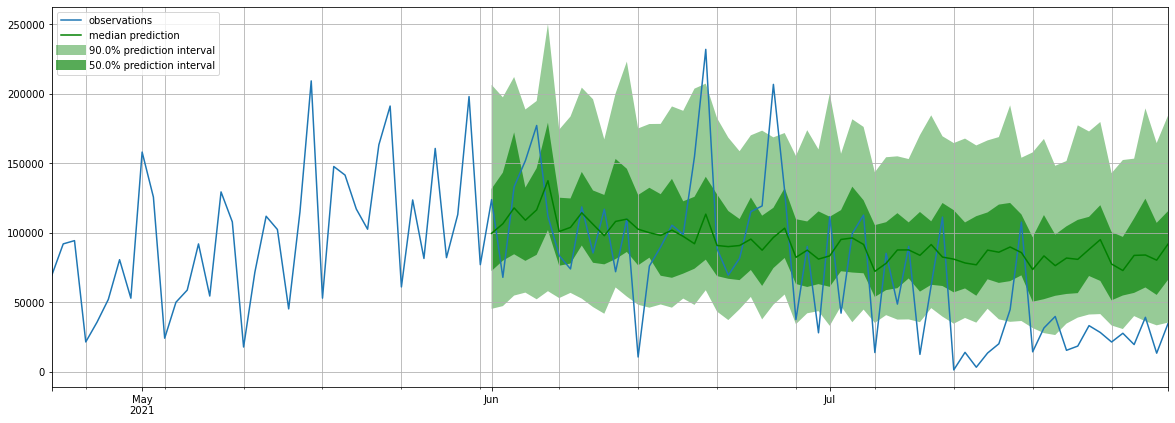

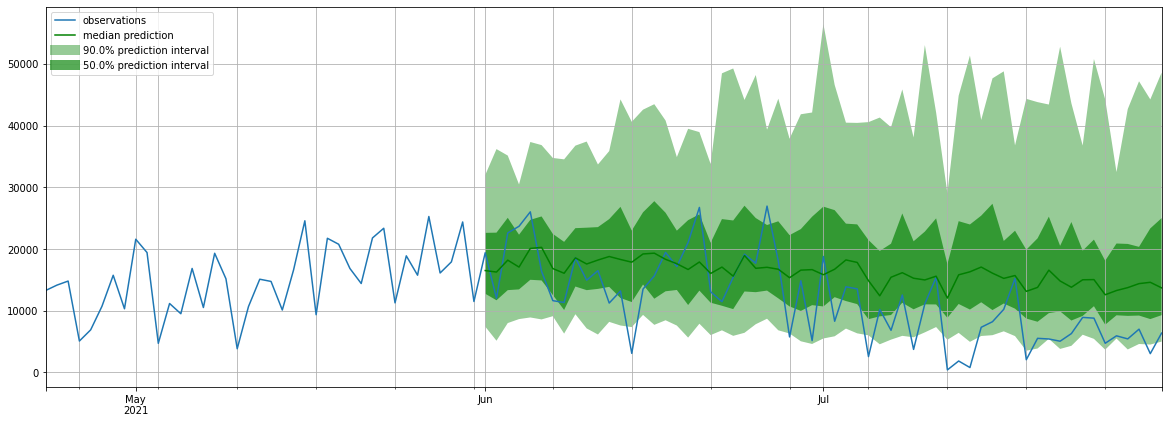

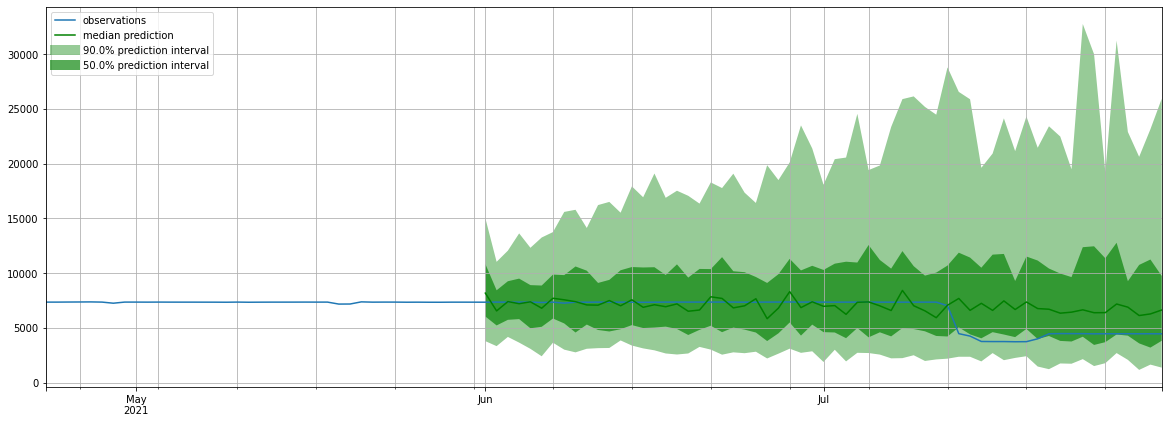

100%|██████████| 100/100 [00:57<00:00,  1.75it/s, epoch=10/10, avg_epoch_loss=6.62]


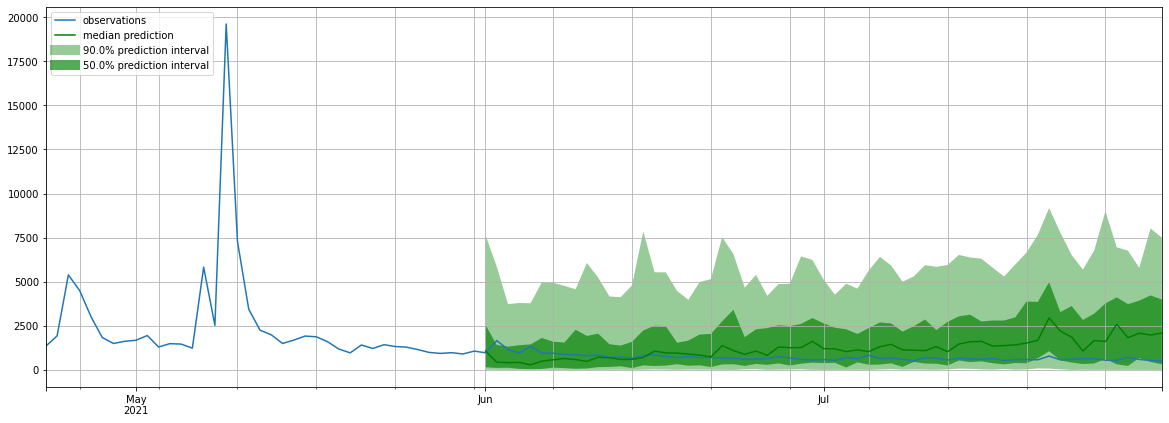

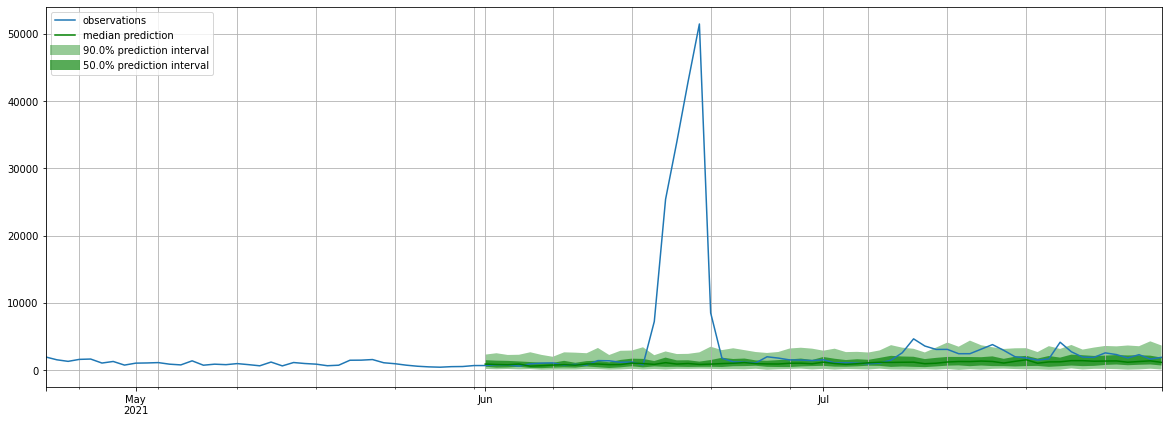

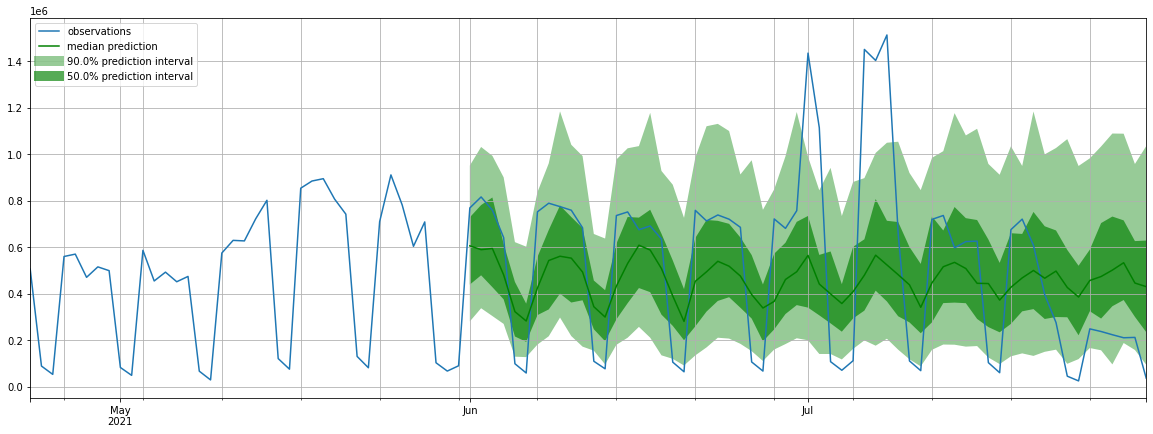

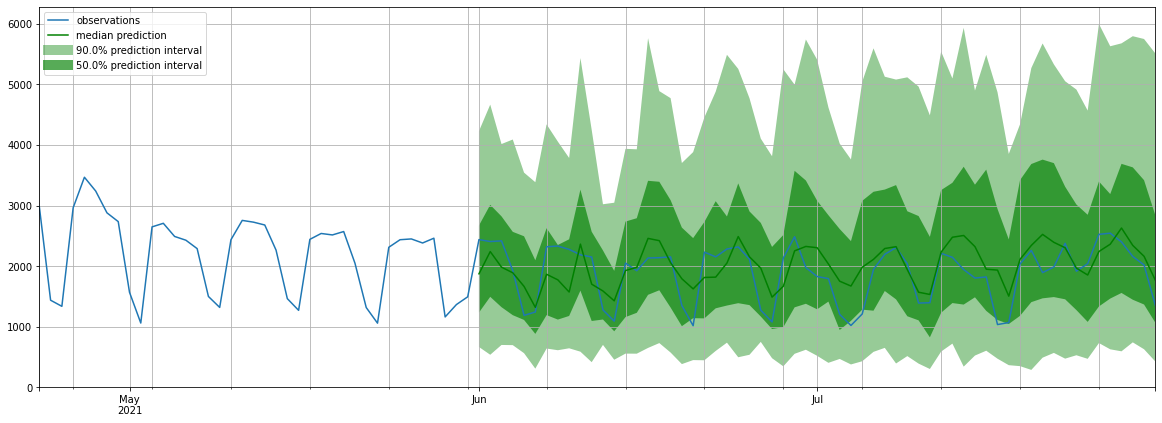

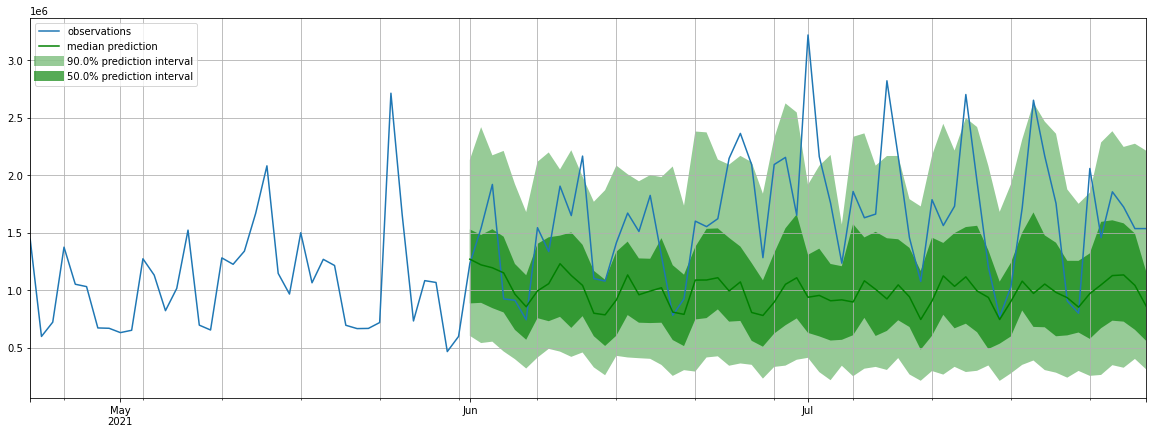

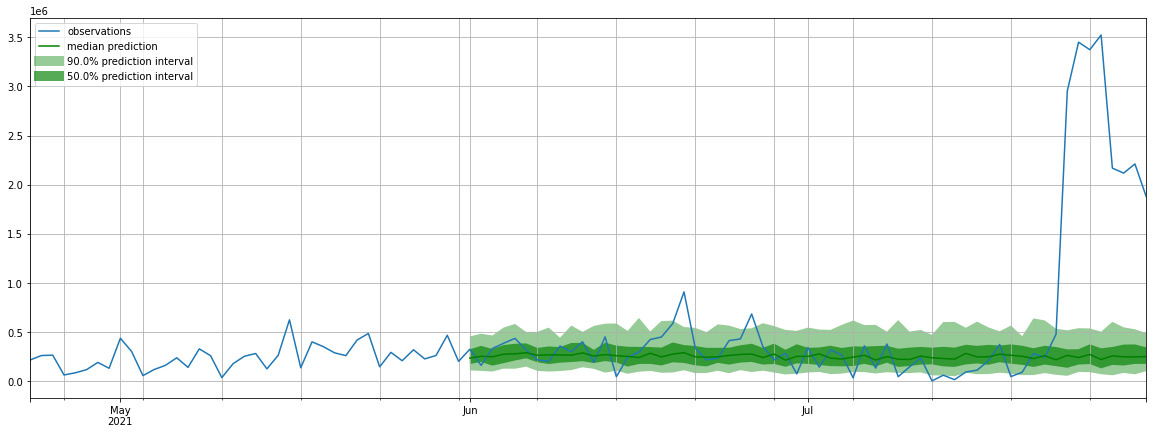

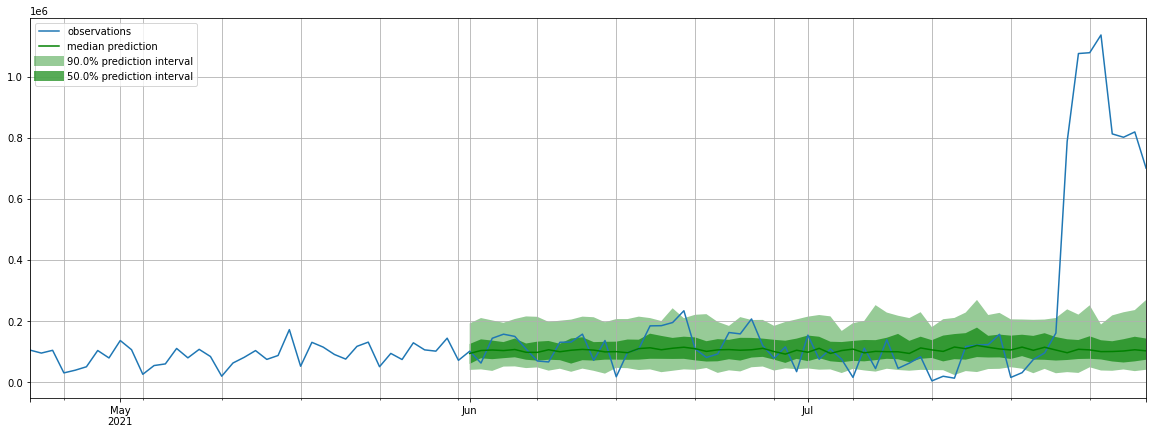

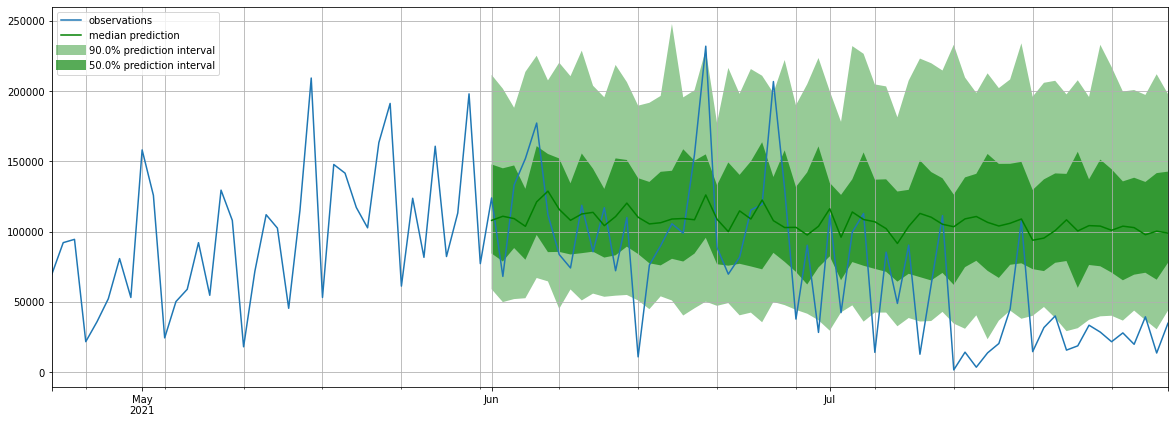

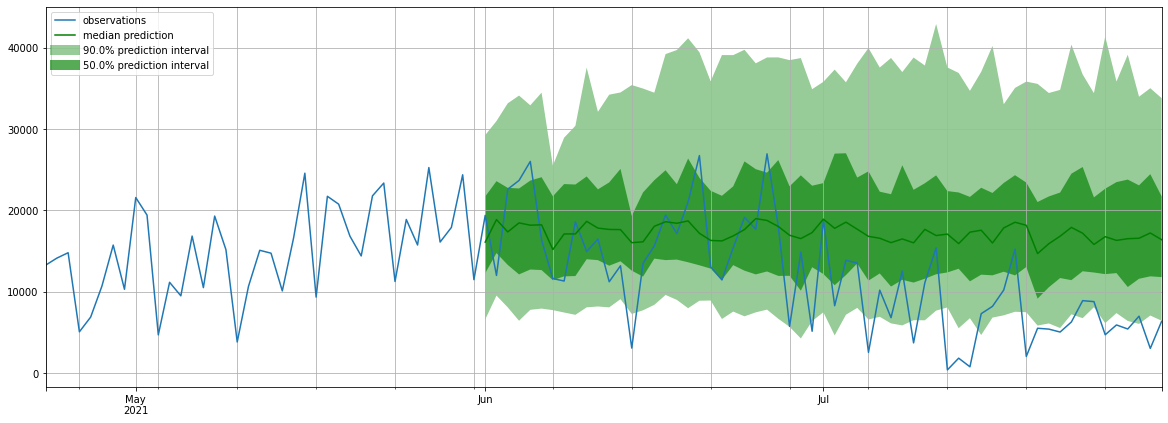

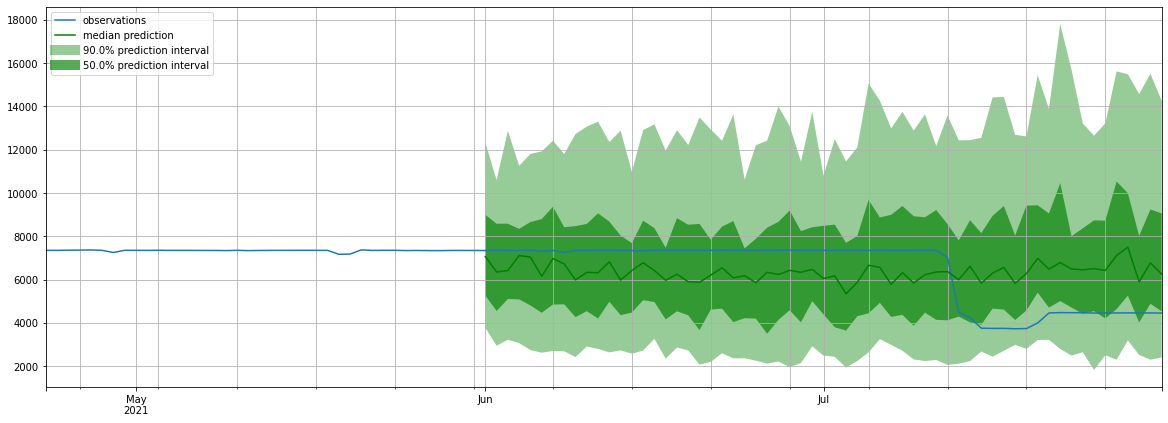

Running evaluation: 100%|██████████| 505/505 [00:00<00:00, 4722.92it/s]


In [27]:
agg_results = []
item_results = []
forecast_results = []
look_back = 1
for look_back in [1,2,3,4,5]:
    deepAR_estimator = DeepAREstimator(
        prediction_length=ds_meta['prediction_length'],
        context_length=ds_meta['prediction_length']*look_back,
        freq=ds_meta['freq'],
        num_layers=5,
        num_cells=90,
        distr_output = NegativeBinomialOutput(),
        use_feat_dynamic_real=False,
        use_feat_static_cat=False,
    #    cardinality=stat_cat_cardinalities,
        dropout_rate=0.1,
    #    cell_type='lstm',
        trainer=Trainer(   
            ctx=gpu(0),
            learning_rate=lr,
            epochs=10,
            num_batches_per_epoch=100,
            batch_size=64
        )
    )
    deepAR_predictor = deepAR_estimator.train(training_data=train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=deepAR_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    forecast_results.append(forecasts)
    tss = list(ts_it)
    for i in range(10):
        plot_prob_forecasts(tss[i], forecasts[i], plot_length=100, prediction_intervals = (50.0, 90.0))
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    agg_results.append(agg_metrics)
    item_results.append(item_metrics)

In [28]:
agg_results[0]

{'Coverage[0.1]': 0.07235838337932153,
 'Coverage[0.5]': 0.47576692095439044,
 'Coverage[0.9]': 0.8800844018828112,
 'MAE_Coverage': 0.02393009792782561,
 'MAPE': 12.65698406723175,
 'MASE': 81.33408182595491,
 'MSE': 1145935514338.9758,
 'MSIS': 3015.4628979495897,
 'ND': 0.41346794247446167,
 'NRMSE': 4.280303709200601,
 'OWA': nan,
 'QuantileLoss[0.1]': 1031875279.6,
 'QuantileLoss[0.5]': 3185433580.0,
 'QuantileLoss[0.9]': 2773628617.2,
 'RMSE': 1070483.7758410801,
 'abs_error': 3185433625.0,
 'abs_target_mean': 250095.28495374127,
 'abs_target_sum': 7704185253.0,
 'mean_absolute_QuantileLoss': 2330312492.2666664,
 'mean_wQuantileLoss': 0.30247357971555083,
 'sMAPE': 0.6570764153600773,
 'seasonal_error': 28550.678706690196,
 'wQuantileLoss[0.1]': 0.1339369765541644,
 'wQuantileLoss[0.5]': 0.41346793663348064,
 'wQuantileLoss[0.9]': 0.36001582595900744}

In [29]:
for a in agg_results:
    print(json.dumps(a, indent=4))
    print('======================================================')

{
    "MSE": 1145935514338.9758,
    "abs_error": 3185433625.0,
    "abs_target_sum": 7704185253.0,
    "abs_target_mean": 250095.28495374127,
    "seasonal_error": 28550.678706690196,
    "MASE": 81.33408182595491,
    "MAPE": 12.65698406723175,
    "sMAPE": 0.6570764153600773,
    "MSIS": 3015.4628979495897,
    "QuantileLoss[0.1]": 1031875279.6,
    "Coverage[0.1]": 0.07235838337932153,
    "QuantileLoss[0.5]": 3185433580.0,
    "Coverage[0.5]": 0.47576692095439044,
    "QuantileLoss[0.9]": 2773628617.2,
    "Coverage[0.9]": 0.8800844018828112,
    "RMSE": 1070483.7758410801,
    "NRMSE": 4.280303709200601,
    "ND": 0.41346794247446167,
    "wQuantileLoss[0.1]": 0.1339369765541644,
    "wQuantileLoss[0.5]": 0.41346793663348064,
    "wQuantileLoss[0.9]": 0.36001582595900744,
    "mean_absolute_QuantileLoss": 2330312492.2666664,
    "mean_wQuantileLoss": 0.30247357971555083,
    "MAE_Coverage": 0.02393009792782561,
    "OWA": NaN
}
{
    "MSE": 426737952344.508,
    "abs_error": 2989